In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools

import numpy as np
import scipy as sp
import pandas as pd
import gudhi as gh
import networkx as nx

from scipy import stats
from scipy.spatial.distance import cdist

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

from src import depth
from src.depth import DepthPoset
from src.drow import plot_filtred_complex2d, plot_simplex, enumerate_points

from tqdm.notebook import tqdm

# Define SImplicial Trees and Depth Posets

In [3]:
def get_random_reordered_stree(stree, change=1.):
    order = np.array([simplex for simplex, value in stree.get_filtration()], dtype=object)
    dims = np.array([len(s) for s in order])
    new_order = []
    for dim in np.unique(dims):
        order_dim = order[dims == dim]
        old_index_change = np.random.choice(np.arange(len(order_dim)), int(change*len(order_dim)), replace=False)
        new_index_change = np.random.choice(old_index_change, len(old_index_change), replace=False)
        order_dim[old_index_change] = order_dim[new_index_change]
        new_order.extend(order_dim)
        
    new_stree = gh.SimplexTree()
    for value, simplex in enumerate(new_order):
        new_stree.insert(simplex, value)
    return new_stree

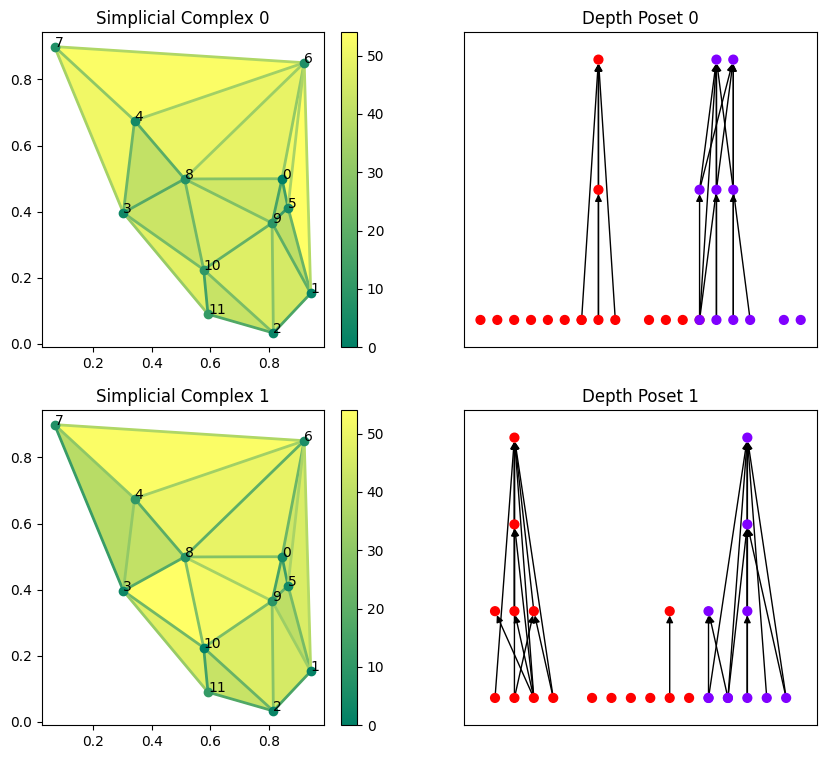

In [4]:
n = 12
dim = 2
points = np.random.random([n, dim])

stree = gh.AlphaComplex(points).create_simplex_tree()
order = []
for d in range(dim + 1):
    for simplex, value in stree.get_filtration():
        if len(simplex) == d + 1:
            order.append(simplex)
stree0 = gh.SimplexTree()
for value, simplex in enumerate(order):
    stree0.insert(simplex, value)

dp0 = DepthPoset.from_simplex_tree(stree0)


stree1 = get_random_reordered_stree(stree0, change=0.5)
dp1 = DepthPoset.from_simplex_tree(stree1)

fig, axs = plt.subplots(2, 2, figsize=(10, 9))

for i, (stree, dp) in enumerate(zip([stree0, stree1], [dp0, dp1])):
    axs[i, 0].set_title(f'Simplicial Complex {i}')
    sm = plot_filtred_complex2d(stree, points, cmap='summer', ax=axs[i, 0])
    plt.colorbar(sm, ax=axs[i, 0])
    enumerate_points(points, ax=axs[i, 0])
    
    axs[i, 1].set_title(f'Depth Poset {i}')
    cmap = plt.get_cmap('rainbow')
    node_colors = [cmap(node.dim/(dim - 1)) for node in dp0.nodes]
    nx.draw_networkx(dp.get_transitive_closure(), dp.hasse_layout(), 
                     node_color=node_colors, node_size=40, with_labels=False,
                     ax=axs[i, 1])

plt.show()

In [5]:
df_filtrations = pd.DataFrame({'Complex 0': {str(key): value for key, value in stree0.get_filtration()}, 
                               'Complex 1': {str(key): value for key, value in stree1.get_filtration()}})
#df_filtrations[df_filtrations['Complex 0'] != df_filtrations['Complex 1']]
pd.Series({ord: np.linalg.norm(df_filtrations['Complex 1'] - df_filtrations['Complex 0'], ord=ord) for ord in [0, np.inf]})

0.0    23.0
inf    23.0
dtype: float64

# Depth Poset Difference Scores

## Special Scores

In [6]:
def jacard_index(a, b):
    """
    Calculate the Jaccard index
    """
    intersection = set(a) & set(b)
    union = set(a) | set(b)
    if len(union) == 0:
        return 1.0
    return len(intersection) / len(union)

In [7]:
def hausdorff_distance(x, y, metric='euclidean') -> float:
    """
    The Hausdorf Distance between 2 sets

    Parameters:
    -----------
    x: np.ndarray shape (n0, d)
    
    y: np.ndarray shape (n1, d)
    """
    x = np.asarray(x)
    y = np.asarray(y)

    dist_matrix = sp.spatial.distance.cdist(x, y, metric=metric)

    return max(dist_matrix.min(axis=1).max(), dist_matrix.min(axis=0).max())


## Comparing Cells

In [8]:
def jacard_cells(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of cells sets represented in 2 Depth Posets.
    """
    cells0 = [node.source[0] for node in dp0.nodes] + [node.source[1] for node in dp0.nodes]
    cells1 = [node.source[0] for node in dp1.nodes] + [node.source[1] for node in dp1.nodes]
    return jacard_index(cells0, cells1)

In [9]:
jacard_cells(dp0, dp1)

0.9636363636363636

In [10]:
def jacard_nodes_cells(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of nodes sources sets of 2 Depth Posets.
    """
    return jacard_index([node.source for node in dp0.nodes], [node.source for node in dp1.nodes])

In [11]:
jacard_nodes_cells(dp0, dp1)

0.2857142857142857

In [12]:
def jacard_edges_cells(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of nodes sources sets of 2 Depth Posets.
    """
    return jacard_index([(node0.source, node1.source) for node0, node1 in dp0.edges], 
                        [(node0.source, node1.source) for node0, node1 in dp1.edges])
    

In [13]:
jacard_edges_cells(dp0, dp1)

0.034482758620689655

## Comparing Index

In [14]:
def jacard_nodes_bd_index(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of birth-death indices sets represented in 2 Depth Posets.
    """
    bd0 = [(node.birth_index, node.death_index) for node in dp0.nodes]
    bd1 = [(node.birth_index, node.death_index) for node in dp1.nodes]
    return jacard_index(bd0, bd1)

In [15]:
jacard_nodes_bd_index(dp0, dp1)

0.22727272727272727

In [16]:
def jacard_edges_bd_index(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of edge pairs of birth-death indices sets represented in 2 Depth Posets.
    """
    e_bd0 = [(node0.birth_index, node0.death_index, node1.birth_index, node1.death_index) for node0, node1 in dp0.edges]
    e_bd1 = [(node0.birth_index, node0.death_index, node1.birth_index, node1.death_index) for node0, node1 in dp1.edges]
    
    return jacard_index(e_bd0, e_bd1)

In [17]:
jacard_edges_bd_index(dp0, dp1)

0.0

In [18]:
def hausdorff_nodes_bd_index(dp0: DepthPoset, dp1: DepthPoset, metric='euclidean'):
    """
    The Hausdorff distance between birth-death indices sets represented in 2 Depth Posets.
    """
    bd0 = [(node.birth_index, node.death_index) for node in dp0.nodes]
    bd1 = [(node.birth_index, node.death_index) for node in dp1.nodes]
    return hausdorff_distance(bd0, bd1, metric=metric)

In [19]:
hausdorff_nodes_bd_index(dp0, dp1)

np.float64(8.06225774829855)

In [20]:
def hausdorff_edges_bd_index(dp0: DepthPoset, dp1: DepthPoset, metric='euclidean'):
    """
    The Hausdorff distance between edge pairs of birth-death indices sets represented in 2 Depth Posets.
    """
    e_bd0 = np.array([(node0.birth_index, node0.death_index, node1.birth_index, node1.death_index) for node0, node1 in dp0.edges])
    e_bd1 = np.array([(node0.birth_index, node0.death_index, node1.birth_index, node1.death_index) for node0, node1 in dp1.edges])
    
    return hausdorff_distance(e_bd0, e_bd1, metric=metric)

In [21]:
hausdorff_edges_bd_index(dp0, dp1)

np.float64(12.12435565298214)

## Comparing Values

In [22]:
def jacard_nodes_bd_values(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of birth-death values sets represented in 2 Depth Posets.
    """
    bd0 = [(node.birth_value, node.death_value) for node in dp0.nodes]
    bd1 = [(node.birth_value, node.death_value) for node in dp1.nodes]
    return jacard_index(bd0, bd1)

In [23]:
jacard_nodes_bd_values(dp0, dp1)

0.22727272727272727

In [24]:
def jacard_edges_bd_values(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard Index of edge pairs of birth-death indices sets represented in 2 Depth Posets.
    """
    e_bd0 = [(node0.birth_value, node0.death_value, node1.birth_value, node1.death_value) for node0, node1 in dp0.edges]
    e_bd1 = [(node0.birth_value, node0.death_value, node1.birth_value, node1.death_value) for node0, node1 in dp1.edges]
    
    return jacard_index(e_bd0, e_bd1)

In [25]:
jacard_edges_bd_values(dp0, dp1)

0.0

In [26]:
def hausdorff_nodes_bd_values(dp0: DepthPoset, dp1: DepthPoset, metric='euclidean'):
    """
    The Hausdorff distance between birth-death indices sets represented in 2 Depth Posets.
    """
    bd0 = [(node.birth_value, node.death_value) for node in dp0.nodes]
    bd1 = [(node.birth_value, node.death_value) for node in dp1.nodes]
    return hausdorff_distance(bd0, bd1, metric=metric)

In [27]:
hausdorff_nodes_bd_values(dp0, dp1)

np.float64(8.06225774829855)

In [28]:
def hausdorff_edges_bd_values(dp0: DepthPoset, dp1: DepthPoset, metric='euclidean'):
    """
    The Hausdorff distance between edge pairs of birth-death indices sets represented in 2 Depth Posets.
    """
    e_bd0 = np.array([(node0.birth_value, node0.death_value, node1.birth_value, node1.death_value) for node0, node1 in dp0.edges])
    e_bd1 = np.array([(node0.birth_value, node0.death_value, node1.birth_value, node1.death_value) for node0, node1 in dp1.edges])
    
    return hausdorff_distance(e_bd0, e_bd1, metric=metric)

In [29]:
hausdorff_edges_bd_values(dp0, dp1)

np.float64(12.12435565298214)

## Density Distance

In [30]:
from src.density import TriangulationDensity

In [31]:
def get_dp_density(dp: DepthPoset, edge_radius_dict):
    # 
    pos = dp.persistant_layout()
    edge_densities = []
    for edge in dp.edges:
        p0 = np.array(pos[edge[0]])
        p1 = np.array(pos[edge[1]])
        r = edge_radius_dict[edge]

        if r > 0:
            vertices = np.array([p0 + np.array([r, -r]), p0 + np.array([r, r]), p0 + np.array([-r, -r]), 
                                 p1 + np.array([-r, r]), p1 + np.array([-r, -r]), p1 + np.array([r, r])])
            triangles = np.array([[0, 1, 2], [3, 4, 5], [1, 2, 5], [2, 4, 5]])
            values = np.ones(4)
        else:
            vertices = np.array([[1, 0], [0.5, 0], [1, 0.5]])
            triangles = np.array([[0, 1, 2]])
            values = np.zeros(1)

        edge_densities.append(TriangulationDensity(vertices, triangles, values, 0))

    if len(edge_densities) == 0:
        result_density = TriangulationDensity([[1, 0], [0.5, 0], [1, 0.5]], [[0, 1, 2]], [0], 0)
    else: 
        result_density = edge_densities[0]
    for i in range(1, len(edge_densities)):
        result_density = result_density + edge_densities[i]
    return result_density

In [32]:
def get_simplex_neighbours(stree: gh.SimplexTree, simplex):
    # 
    faces = [tuple(simplex) for simplex, _ in stree.get_boundaries(simplex)]
    cofaces_of_faces = []
    for face in faces:
        cofaces_of_faces += [tuple(simplex) for simplex, _ in stree.get_cofaces(face, 1)]
    
    cofaces = [tuple(simplex) for simplex, _ in stree.get_cofaces(simplex, 1)]
    faces_of_cofaces = []
    for coface in cofaces:
        faces_of_cofaces += [tuple(simplex) for simplex, _ in stree.get_boundaries(coface)]
    
    return list(set(cofaces_of_faces + faces_of_cofaces))

In [33]:
simplex = [s for s, v in stree.get_simplices()]
simplex = simplex[np.random.randint(len(simplex))]
simplex               

[1, 2, 9]

In [34]:
get_simplex_neighbours(stree, simplex)

[(2, 9, 10), (1, 2, 9), (1, 5, 9)]

In [35]:
def get_simplex_neighbours_filtrations(stree: gh.SimplexTree, simplex):
    #
    return [stree.filtration(neighbour) for neighbour in get_simplex_neighbours(stree, simplex)]

In [36]:
get_simplex_neighbours_filtrations(stree, simplex)

[47.0, 45.0, 40.0]

In [37]:
def get_edge_radius_dict(stree: gh.SimplexTree, nodes=None):
    # 
    simplex_neighbours_filtrations_dict = {tuple(simplex): get_simplex_neighbours_filtrations(stree, simplex) for simplex, _ in stree.get_simplices()}

    if nodes is None:
        cond = lambda s0, s1, s2, s3: (len(s1) - len(s0) == 1) and (len(s3) - len(s2) == 1) and (len(s0) == len(s2))
        get_arg = lambda s0, s1, s2, s3: ((s0, s1), (s2, s3))
    else:
        source_list = [node.source for node in nodes]
        cond = lambda s0, s1, s2, s3: ((s0, s1) in source_list) and ((s2, s3) in source_list)
        get_arg = lambda s0, s1, s2, s3: ([node for node in nodes if node.source == (s0, s1)][0], 
                                          [node for node in nodes if node.source == (s2, s3)][0])
        
    edge_radius_dict = {}
    for s0, s1, s2, s3 in itertools.product(simplex_neighbours_filtrations_dict.keys(), repeat=4):
        if cond(s0, s1, s2, s3):
            arr0 = np.concatenate([simplex_neighbours_filtrations_dict[s0], 
                                   simplex_neighbours_filtrations_dict[s1]])
            arr1 = np.concatenate([simplex_neighbours_filtrations_dict[s2], 
                                   simplex_neighbours_filtrations_dict[s3]])
            value = cdist(arr0.reshape(-1, 1), arr1.reshape(-1, 1)).min()
            edge_radius_dict.update({get_arg(s0, s1, s2, s3): value})
    return edge_radius_dict

In [38]:
edge_radius_dict = get_edge_radius_dict(stree0)
edge_radius_dict = pd.Series(edge_radius_dict)

edge_radius_dict

((0, 5), (0, 5, 6))  ((0, 5), (0, 5, 6))    0.0
                     ((0, 5), (0, 5, 9))    0.0
                     ((0, 5), (0, 6, 8))    0.0
                     ((0, 5), (0, 8, 9))    0.0
                     ((0, 5), (1, 2, 9))    0.0
                                           ... 
((11,), (10, 11))    ((11,), (6, 8))        0.0
                     ((11,), (8, 9))        0.0
                     ((11,), (8, 10))       0.0
                     ((11,), (9, 10))       0.0
                     ((11,), (10, 11))      0.0
Length: 291600, dtype: float64

In [39]:
edge_radius_dict.value_counts()

0.0    270656
1.0     20944
Name: count, dtype: int64

In [40]:
edge_radius_dict = get_edge_radius_dict(stree0, dp0.nodes)
edge_radius_dict_series = pd.Series(edge_radius_dict)

edge_radius_dict_series.value_counts()

0.0    609
1.0    120
Name: count, dtype: int64

In [41]:
edge_radius_dict_series[dp0.edges]

(2,9),(1,2,9)     (9,10),(2,9,10)    0.0
(0,8),(0,8,9)     (8,9),(8,9,10)     0.0
(8,9),(8,9,10)    (9,10),(2,9,10)    0.0
(2,10),(2,10,11)  (9,10),(2,9,10)    0.0
11,(10,11)        10,(2,11)          0.0
10,(2,11)         3,(8,10)           0.0
                  1,(1,9)            0.0
9,(5,9)           5,(0,5)            0.0
5,(0,5)           1,(1,9)            0.0
8,(3,8)           4,(4,8)            0.0
4,(4,8)           3,(8,10)           0.0
2,(1,2)           1,(1,9)            0.0
dtype: float64

/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:228: RuntimeWarning: invalid value encountered in divide
  t = d0_cross_d2 / d1_cross_d2
/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:229: RuntimeWarning: invalid value encountered in divide
  u = cross(b0 - a0, d1) / d1_cross_d2
/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:228: RuntimeWarning: divide by zero encountered in divide
  t = d0_cross_d2 / d1_cross_d2
/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:229: RuntimeWarning: divide by zero encountered in divide
  u = cross(b0 - a0, d1) / d1_cross_d2


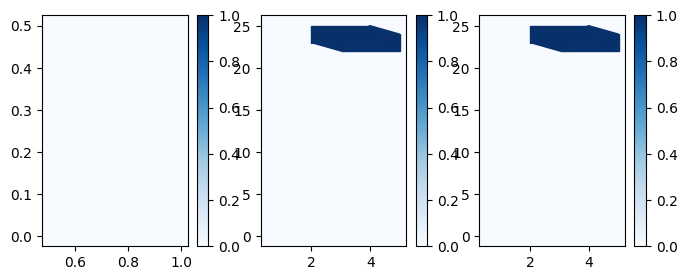

In [42]:
edge_radius_dict0 = get_edge_radius_dict(stree0, dp0.nodes)
edge_radius_dict1 = get_edge_radius_dict(stree1, dp1.nodes)

dens0 = get_dp_density(dp0, edge_radius_dict0)
dens1 = get_dp_density(dp1, edge_radius_dict1)

dens_abs = abs(dens0 - dens1)

fig, axs = plt.subplots(1, 3, figsize=(8, 3))

sm = dens0.show(ax=axs[0])
plt.colorbar(sm, ax=axs[0])

sm = dens1.show(ax=axs[1])
plt.colorbar(sm, ax=axs[1])

sm = dens_abs.show(ax=axs[2])
plt.colorbar(sm, ax=axs[2])

In [43]:
def density_distance(stree0: gh.SimplexTree, stree1: gh.SimplexTree, dp0=None, dp1=None):
    """
    """
    if dp0 is None:
        dp0 = DepthPoset.from_simplex_tree(stree0)
    if dp1 is None:
        dp1 = DepthPoset.from_simplex_tree(stree1)

    edge_radius_dict0 = get_edge_radius_dict(stree0, dp0.nodes)
    edge_radius_dict1 = get_edge_radius_dict(stree1, dp1.nodes)

    dens0 = get_dp_density(dp0, edge_radius_dict0)
    dens1 = get_dp_density(dp1, edge_radius_dict1)

    dens_abs = abs(dens0 - dens1)
    return dens_abs.integral()

In [44]:
density_distance(stree0, stree1, dp0, dp1)

np.float64(8.0)

# Set of Filtrations on 1 Complex

## Random Model Description and Generating

### Set Parameters

In [45]:
n_filtrations = 8
scale = 0.01
p = 0.1

n = 8
dim = 2
points = np.random.random([n, dim])

stree = gh.AlphaComplex(points).create_simplex_tree()

### Model Description

In [46]:
model_description = f'''
\\par For the given simplicial complex, defined by Delaunay triangulation of $n = {n}$ points uniformly distributed in $[0, 1]^{{{dim}}}$
we define the original filtration in the way:
$$
f(s) - \\dim(s) + x, \\; \\text{{where}}\\; x\\sim \\mathcal{{U}}[0, 1]
$$
\\par Then we are defining $n_f = {n_filtrations}$ filtrations as series, 
s.t. for each $i$-th filtration and simplex $s$ we define the $i+1$-th filtration by adding normal distributed value with scale {scale}:
$$
f_{{i+1}}(s) = 
\\begin{{cases}}
f_i(s) + x\\sim \\mathcal{{N}}(0, {scale}), \\; \\text{{if}} \\; p < {p} \\\\
f_i(s), \\;  \\text{{if}} \\; p \\geq {p} 
\\end{{cases}}, \\; p\\sim \\mathcal{{U}}[0, 1]
$$
and then we normolize each filtration for each dimension:
$$
f_i^{{norm}}(s) = \\cfrac
{{f_i(s) - \\min\\limits_{{\\dim(s) = \\dim(\\sigma)}}f_i(\\sigma)}}
{{\\max\\limits_{{\\dim(s) = \\dim(\\sigma)}}f_i(\\sigma) - \\min\\limits_{{\\dim(s) = \\dim(\\sigma)}}f_i(\\sigma)}} + \\dim(s)
$$

'''.strip()

print(model_description)

\par For the given simplicial complex, defined by Delaunay triangulation of $n = 8$ points uniformly distributed in $[0, 1]^{2}$
we define the original filtration in the way:
$$
f(s) - \dim(s) + x, \; \text{where}\; x\sim \mathcal{U}[0, 1]
$$
\par Then we are defining $n_f = 8$ filtrations as series, 
s.t. for each $i$-th filtration and simplex $s$ we define the $i+1$-th filtration by adding normal distributed value with scale 0.01:
$$
f_{i+1}(s) = 
\begin{cases}
f_i(s) + x\sim \mathcal{N}(0, 0.01), \; \text{if} \; p < 0.1 \\
f_i(s), \;  \text{if} \; p \geq 0.1 
\end{cases}, \; p\sim \mathcal{U}[0, 1]
$$
and then we normolize each filtration for each dimension:
$$
f_i^{norm}(s) = \cfrac
{f_i(s) - \min\limits_{\dim(s) = \dim(\sigma)}f_i(\sigma)}
{\max\limits_{\dim(s) = \dim(\sigma)}f_i(\sigma) - \min\limits_{\dim(s) = \dim(\sigma)}f_i(\sigma)} + \dim(s)
$$


\par For the given simplicial complex, defined by Delaunay triangulation of $n = 8$ points uniformly distributed in $[0, 1]^{2}$
we define the original filtration in the way:
$$
f(s) - \dim(s) + x, \; \text{where}\; x\sim \mathcal{U}[0, 1]
$$
\par Then we are defining $n_f = 20$ filtrations as series, 
s.t. for each $i$-th filtration and simplex $s$ we define the $i+1$-th filtration by adding normal distributed value with scale 0.01:
$$
f_{i+1}(s) = 
\begin{cases}
f_i(s) + x\sim \mathcal{N}(0, 0.01), \; \text{if} \; p < 0.2 \\
f_i(s), \;  \text{if} \; p \geq 0.2 
\end{cases}, \; p\sim \mathcal{U}[0, 1]
$$
and then we normolize each filtration for each dimension:
$$
f_i^{norm}(s) = \cfrac
{f_i(s) - \min\limits_{\dim(s) = \dim(\sigma)}f_i(\sigma)}
{\max\limits_{\dim(s) = \dim(\sigma)}f_i(\sigma) - \min\limits_{\dim(s) = \dim(\sigma)}f_i(\sigma)} + \dim(s)
$$

### Generate Filtrations by the Model

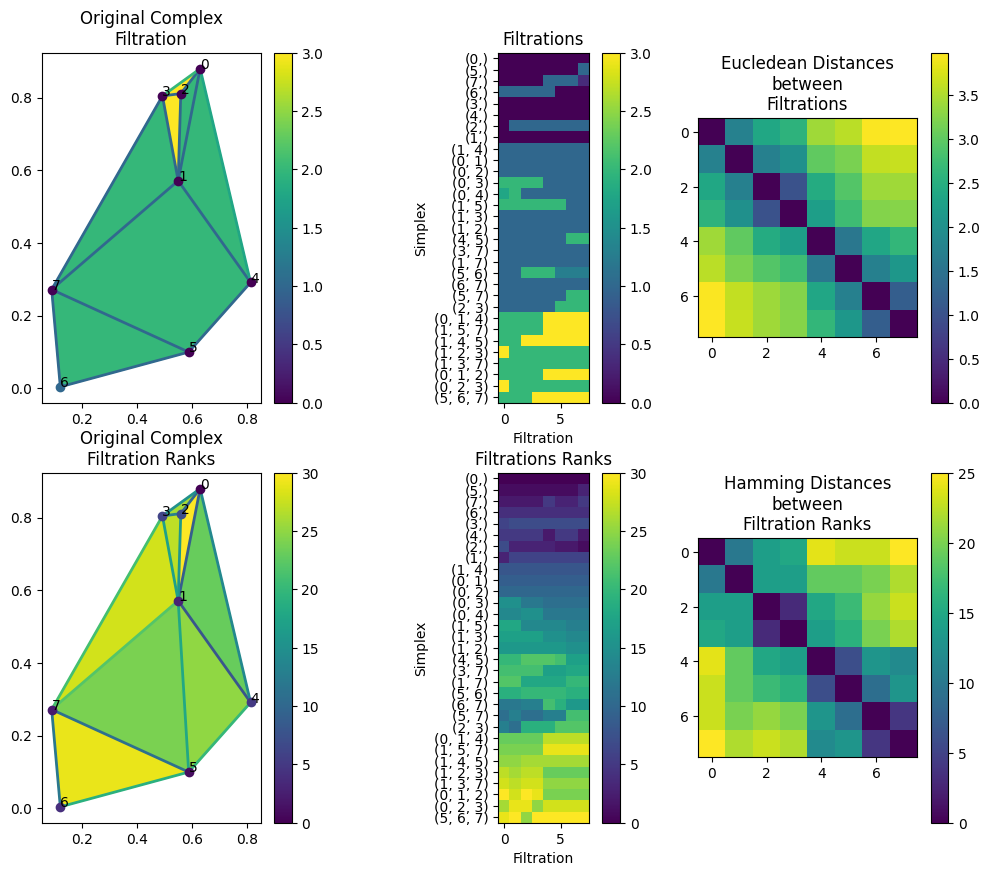

In [47]:
# get simplices and dimensions arrays
simplices = np.array([tuple(s) for s, f_val in stree.get_simplices()], dtype=object)

simplices_dimensions = np.array([len(s) - 1 for s in simplices])
simplices = simplices[simplices_dimensions.argsort()]
simplices_dimensions = np.array([len(s) - 1 for s in simplices])

# generate original filtration
filtrations = np.random.random(len(simplices)) * np.ones([n_filtrations, len(simplices)])

# generate cumulatative normal adding part
filtrations_add = np.random.normal(scale=scale, size=[n_filtrations, len(simplices)])
filtrations_add[0] = 0
filtrations_add[np.random.random(filtrations_add.shape) > p] = 0
filtrations_add = np.cumsum(filtrations_add, axis=0)

# get next filtrations
filtrations = filtrations + filtrations_add
divider = filtrations.max(axis=0) - filtrations.min(axis=0)
divider[divider == 0] = 1
filtrations = (filtrations - filtrations.min(axis=0)) / divider
for d in range(dim + 1):
    filtrations[:, simplices_dimensions == d] += d

# get filtrations_rank
filtrations_rank = filtrations.argsort(axis=1)

# find distances between filtrations
filtrations_distances = cdist(filtrations, filtrations, metric='euclidean')
filtrations_rank_distances = cdist(filtrations_rank, filtrations_rank, metric='hamming')*len(simplices)

# define coresponding simplicial complexes
stree_original = gh.SimplexTree()
for simplex, value in zip(simplices, filtrations[0]):
    stree_original.insert(simplex, value)
stree_original_ranked = gh.SimplexTree()
for simplex, value in zip(simplices, filtrations_rank[0]):
    stree_original_ranked.insert(simplex, value)


# 
fig, axs = plt.subplots(2, 3, figsize=(12, 10))

axs[0, 0].set_title('Original Complex\nFiltration')
sm = plot_filtred_complex2d(stree_original, points, ax=axs[0, 0], cmap='viridis', vmin=0, vmax=dim+1)
plt.colorbar(sm, ax=axs[0, 0])
enumerate_points(points, ax=axs[0, 0])

axs[0, 1].set_title('Filtrations')
sm = axs[0, 1].imshow(filtrations.transpose(), vmin=0, vmax=dim+1)
plt.colorbar(sm, ax=axs[0, 1])
axs[0, 1].set_ylabel('Simplex')
axs[0, 1].set_xlabel('Filtration')
axs[0, 1].set_yticks(np.arange(len(simplices)), simplices)

axs[0, 2].set_title('Eucledean Distances\nbetween\nFiltrations')
sm = axs[0, 2].imshow(filtrations_distances.transpose())
plt.colorbar(sm, ax=axs[0, 2])


axs[1, 0].set_title('Original Complex\nFiltration Ranks')
sm = plot_filtred_complex2d(stree_original_ranked, points, ax=axs[1, 0], cmap='viridis')
plt.colorbar(sm, ax=axs[1, 0])
enumerate_points(points, ax=axs[1, 0])

axs[1, 1].set_title('Filtrations Ranks')
sm = axs[1, 1].imshow(filtrations_rank.transpose())
plt.colorbar(sm, ax=axs[1, 1])
axs[1, 1].set_ylabel('Simplex')
axs[1, 1].set_xlabel('Filtration')
axs[1, 1].set_yticks(np.arange(len(simplices)), simplices)

axs[1, 2].set_title('Hamming Distances\nbetween\nFiltration Ranks')
sm = axs[1, 2].imshow(filtrations_rank_distances.transpose())
plt.colorbar(sm, ax=axs[1, 2])

plt.savefig('pics/Comparing Filtrations - filtrations.png')

## Generate Simplicial Complexes and Depth Posets

In [48]:
strees = []

# generate simplicial complexes
for i_filtrations in tqdm(range(n_filtrations), total=n_filtrations, desc='Generate Simplex Complexes'):
    filtration = filtrations[i_filtrations]
    strees.append(gh.SimplexTree())
    for simplex, value in zip(simplices, filtration):
        strees[-1].insert(simplex, value)

dps = [DepthPoset.from_simplex_tree(stree) for stree in tqdm(strees, total=n_filtrations, desc='Generate Depth Posets')]

Generate Simplex Complexes:   0%|          | 0/8 [00:00<?, ?it/s]

Generate Depth Posets:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

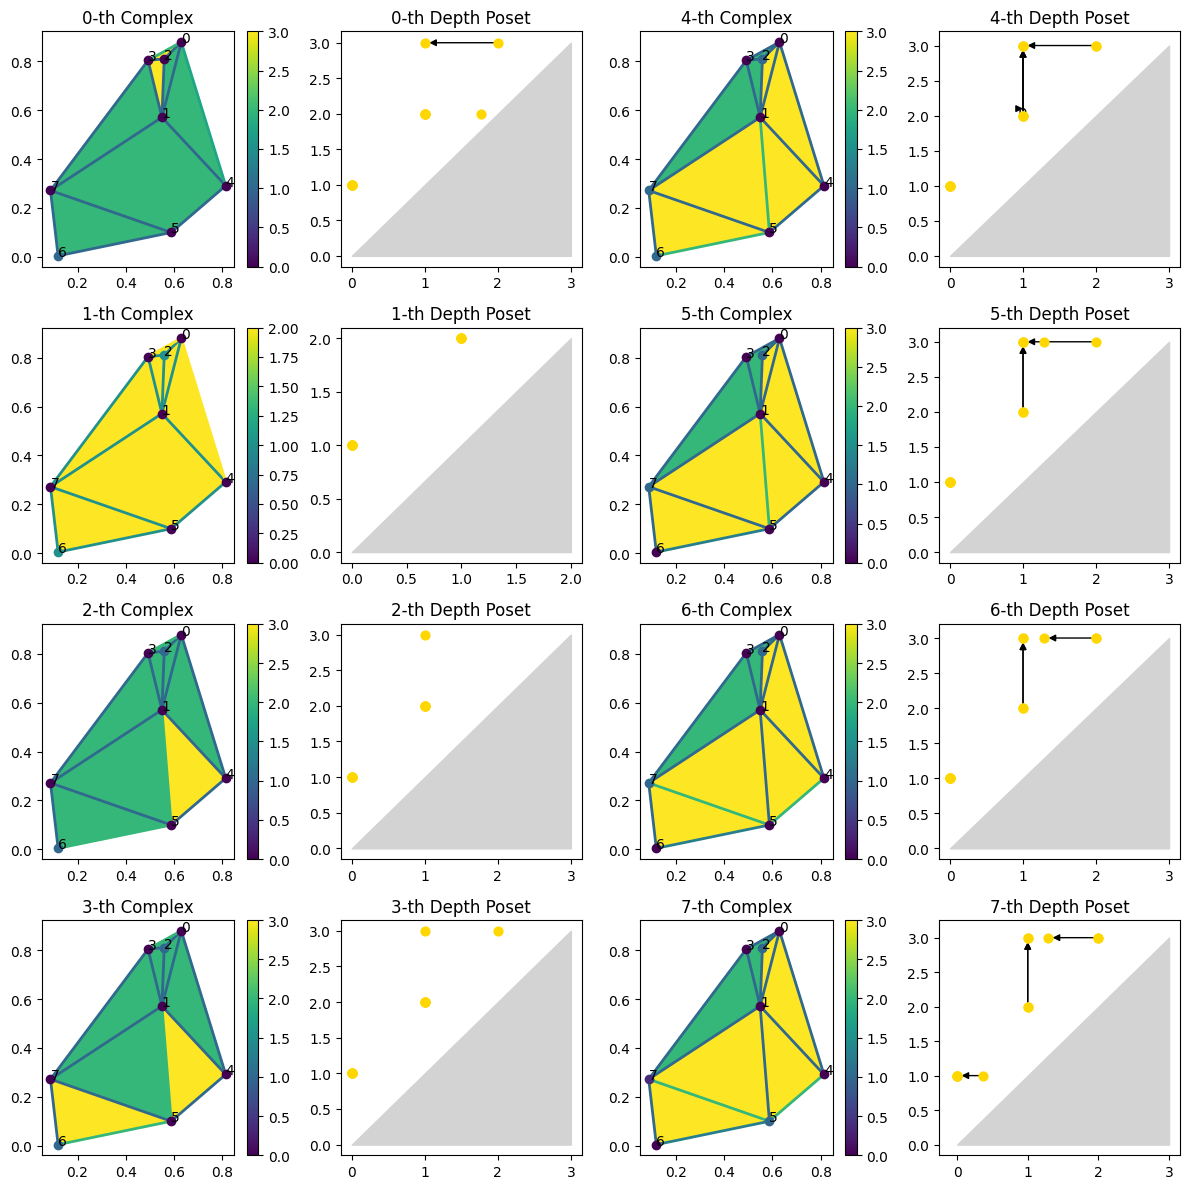

In [49]:
n_rows = int(np.ceil(0.5*n_filtrations))
fig, axs = plt.subplots(n_rows, 4, figsize=(12, n_rows*3))

for i in tqdm(range(n_filtrations), total=n_filtrations):
    i_row = i%n_rows
    i_col = i//n_rows*2
    
    axs[i_row, i_col + 0].set_title(f'{i}-th Complex')
    sm = plot_filtred_complex2d(strees[i], points, ax=axs[i_row, i_col + 0])
    plt.colorbar(sm, ax=axs[i_row, i_col + 0])
    enumerate_points(points, ax=axs[i_row, i_col + 0])
    
    axs[i_row, i_col + 1].set_title(f'{i}-th Depth Poset')
    nx.draw_networkx(dps[i].get_transitive_closure(), dps[i].persistant_layout(), 
                     node_color='gold', node_size=40, with_labels=False,
                     ax=axs[i_row, i_col + 1], hide_ticks=False)
    axs[i_row, i_col + 1].fill_between([filtrations[i].min(), filtrations[i].max()],
                                       [filtrations[i].min(), filtrations[i].min()],
                                       [filtrations[i].min(), filtrations[i].max()],
                                       color='lightgrey')

plt.tight_layout()
plt.savefig('pics/Comparing Filtrations - complexes and depth posets.png')

## Apply Scores

In [50]:
scores_list = [jacard_cells, 
               jacard_nodes_cells, 
               jacard_edges_cells, 
               jacard_nodes_bd_index, 
               jacard_edges_bd_index, 
               hausdorff_nodes_bd_index, 
               hausdorff_edges_bd_index, 
               jacard_nodes_bd_values, 
               jacard_edges_bd_values, 
               hausdorff_nodes_bd_values, 
               hausdorff_edges_bd_values, 
               density_distance, 
              ]
len(scores_list)

12

In [51]:
cdists = np.nan*np.empty([len(scores_list), n_filtrations, n_filtrations], dtype=float)

with tqdm(total=np.prod(cdists.shape)) as pbar:
    for i, j in itertools.product(range(n_filtrations), repeat=2):
        dpi, dpj = dps[i], dps[j]
        streei, streej = strees[i], strees[j]
        for i_score, score in enumerate(scores_list):
            try:
                value = score(streei, streej, dpi, dpj)
            except TypeError:
                value = score(dpi, dpj)
            cdists[i_score, i, j] = value
            pbar.update()

  0%|          | 0/768 [00:00<?, ?it/s]

/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:228: RuntimeWarning: invalid value encountered in divide
  t = d0_cross_d2 / d1_cross_d2
/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:229: RuntimeWarning: invalid value encountered in divide
  u = cross(b0 - a0, d1) / d1_cross_d2
/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:228: RuntimeWarning: divide by zero encountered in divide
  t = d0_cross_d2 / d1_cross_d2
/home/feodor/Jupyter/depth-poset/src/planar_geometry.py:229: RuntimeWarning: divide by zero encountered in divide
  u = cross(b0 - a0, d1) / d1_cross_d2


ValueError: XB must be a 2-dimensional array.

In [ ]:
assert (cdists.transpose([0, 2, 1]) == cdists).all()

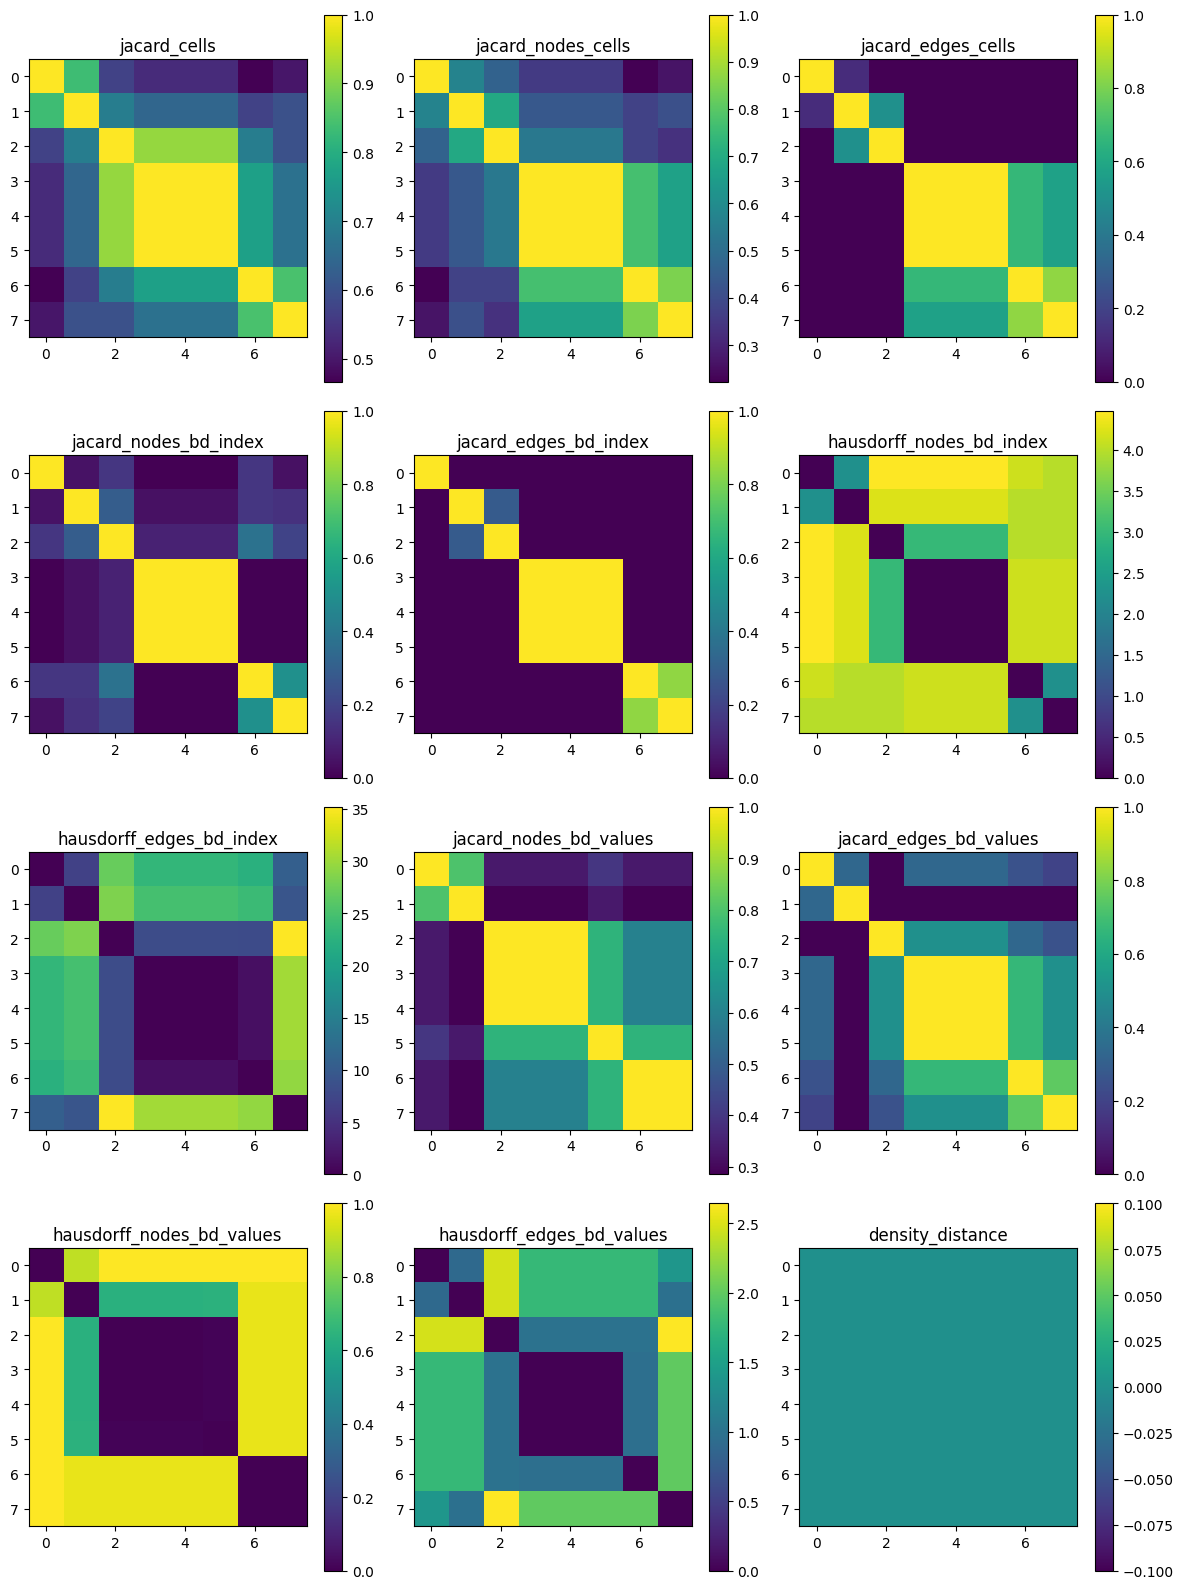

In [ ]:
n_elements = len(scores_list)# + 2
n_cols = int(np.ceil(n_elements**0.5))
n_rows = int(np.ceil(n_elements/n_cols))


fig, axs = plt.subplots(n_cols, n_rows, figsize=(4*n_rows, 4*n_cols))

for i_score, score in enumerate(scores_list):
    i_row = i_score//n_rows
    i_col = i_score%n_rows

    axs[i_row, i_col].set_title(score.__name__)
    sm = axs[i_row, i_col].imshow(cdists[i_score])
    plt.colorbar(sm, ax=axs[i_row, i_col])

plt.tight_layout()
plt.savefig('pics/Comparing Filtrations - scores.png')

## Checking the Dependicies

### Compare just Distances between Filtrations

In [ ]:
from sortedcontainers import SortedList

def count_inversions(arr):
    """Counts the number of inversions in the given array using a SortedList."""
    inversions = 0
    sorted_list = SortedList()
    for num in arr:
        # Count how many numbers in sorted_list are greater than num
        inversions += len(sorted_list) - sorted_list.bisect_right(num)
        sorted_list.add(num)
    return inversions

def transpositions_needed(arr1, arr2):
    """
    Computes the number of adjacent transpositions needed 
    to transform arr1 into arr2.
    
    Parameters:
        arr1, arr2: Two NumPy arrays containing the same elements in different orders.
    
    Returns:
        Number of transpositions (inversions) needed.
    """
    if set(arr1) != set(arr2):
        raise ValueError("Both arrays must contain the same elements in a different order.")

    # Map arr2 into the rank order of arr1
    rank_map = {value: i for i, value in enumerate(arr2)}
    arr1_mapped = np.array([rank_map[x] for x in arr1])

    # Count transpositions
    return count_inversions(arr1_mapped)

# Example usage
a = np.array([3, 1, 2, 4])
b = np.array([1, 2, 3, 4])

print("Number of transpositions:", transpositions_needed(a, b))


Number of transpositions: 2


In [ ]:
filtrations_rank_transpositions = np.nan*np.zeros([n_filtrations, n_filtrations])
for (i, filtration_i), (j, filtration_j) in itertools.product(enumerate(filtrations_rank), repeat=2):
    filtrations_rank_transpositions[i, j] = transpositions_needed(filtration_i, filtration_j)

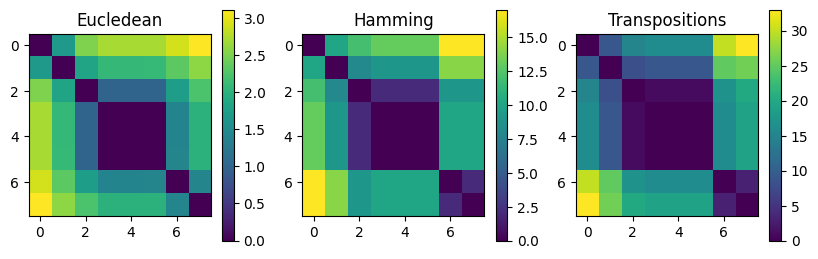

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

axs[0].set_title('Eucledean')
sm = axs[0].imshow(filtrations_distances)
plt.colorbar(sm, ax=axs[0])

axs[1].set_title('Hamming')
sm = axs[1].imshow(filtrations_rank_distances)
plt.colorbar(sm, ax=axs[1])

axs[2].set_title('Transpositions')
sm = axs[2].imshow(filtrations_rank_transpositions)
plt.colorbar(sm, ax=axs[2])

plt.show()

In [ ]:
triu = np.triu(np.ones([n_filtrations, n_filtrations], dtype=bool))

df_distances = pd.DataFrame({'Eucledean': filtrations_distances[triu], 
                             'Hamming': filtrations_rank_distances[triu], 
                             'Transpositions': filtrations_rank_transpositions[triu]
                            }, 
                            index=map(tuple, np.array(np.where(triu)).transpose())
                           )
print(f'df_distances.shape = {df_distances.shape}')
df_distances.head()

df_distances.shape = (36, 3)


,Eucledean,Hamming,Transpositions
"(0, 0)",0.000000,0.0,0.0
"(0, 1)",1.679026,10.0,9.0
"(0, 2)",2.511329,12.0,15.0
"(0, 3)",2.703104,13.0,16.0
"(0, 4)",2.703104,13.0,16.0


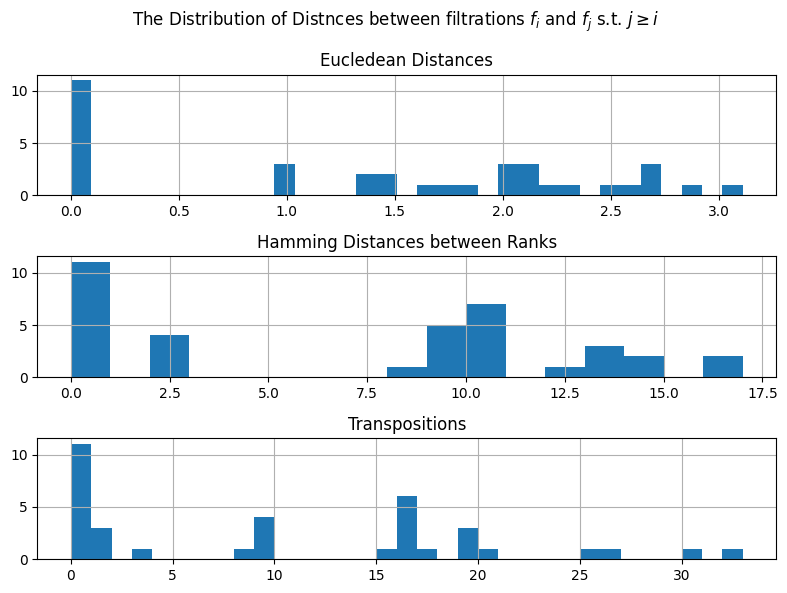

In [ ]:
fig, axs = plt.subplots(3, figsize=(8, 6))

fig.suptitle(r'The Distribution of Distnces between filtrations $f_i$ and $f_j$ s.t. $j\geq i$')

axs[0].set_title(r'Eucledean Distances')
axs[0].hist(df_distances['Eucledean'], bins=len(simplices))
axs[0].grid(True)

axs[1].set_title(r'Hamming Distances between Ranks')
axs[1].hist(df_distances['Hamming'], bins=df_distances['Hamming'].max().astype(int))
axs[1].grid(True)

axs[2].set_title(r'Transpositions')
axs[2].hist(df_distances['Transpositions'], bins=df_distances['Transpositions'].max().astype(int))
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Pearson correlation
df_distance_pearson = []

for col0, col1 in itertools.combinations(df_distances.columns, 2):
    corr, p_value = stats.pearsonr(df_distances[col0], df_distances[col1])
    df_distance_pearson.append({'distances': (col0, col1), 
                                'correlation': corr, 
                                'p-value': p_value})

df_distance_pearson = pd.DataFrame(df_distance_pearson)
df_distance_pearson

,distances,correlation,p-value
0,"(Eucledean, Hamming)",0.952094,4.551618e-19
1,"(Eucledean, Transpositions)",0.869574,5.898256e-12
2,"(Hamming, Transpositions)",0.944198,5.729241e-18


### The Scores Distribution

In [ ]:
df_score_values = pd.DataFrame({score.__name__: cdists[i_score, triu] for i_score, score in enumerate(scores_list)}, 
                               index=map(tuple, np.array(np.where(triu)).transpose())
                        )
print(f'df_score_values.shape = {df_score_values.shape}')
df_score_values.head()

df_score_values.shape = (36, 12)


,jacard_cells,jacard_nodes_cells,jacard_edges_cells,jacard_nodes_bd_index,jacard_edges_bd_index,hausdorff_nodes_bd_index,hausdorff_edges_bd_index,jacard_nodes_bd_values,jacard_edges_bd_values,hausdorff_nodes_bd_values,hausdorff_edges_bd_values,density_distance
"(0, 0)",1.000000,1.000000,1.000,1.000000,1.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0
"(0, 1)",0.833333,0.571429,0.125,0.047619,0.0,2.236068,6.782330,0.800000,0.333333,0.905057,0.905057,0.0
"(0, 2)",0.571429,0.466667,0.000,0.157895,0.0,4.472136,26.944387,0.333333,0.000000,1.000000,2.475509,0.0
"(0, 3)",0.533333,0.352941,0.000,0.000000,0.0,4.472136,23.259407,0.333333,0.333333,1.000000,1.768657,0.0
"(0, 4)",0.533333,0.352941,0.000,0.000000,0.0,4.472136,23.259407,0.333333,0.333333,1.000000,1.768657,0.0


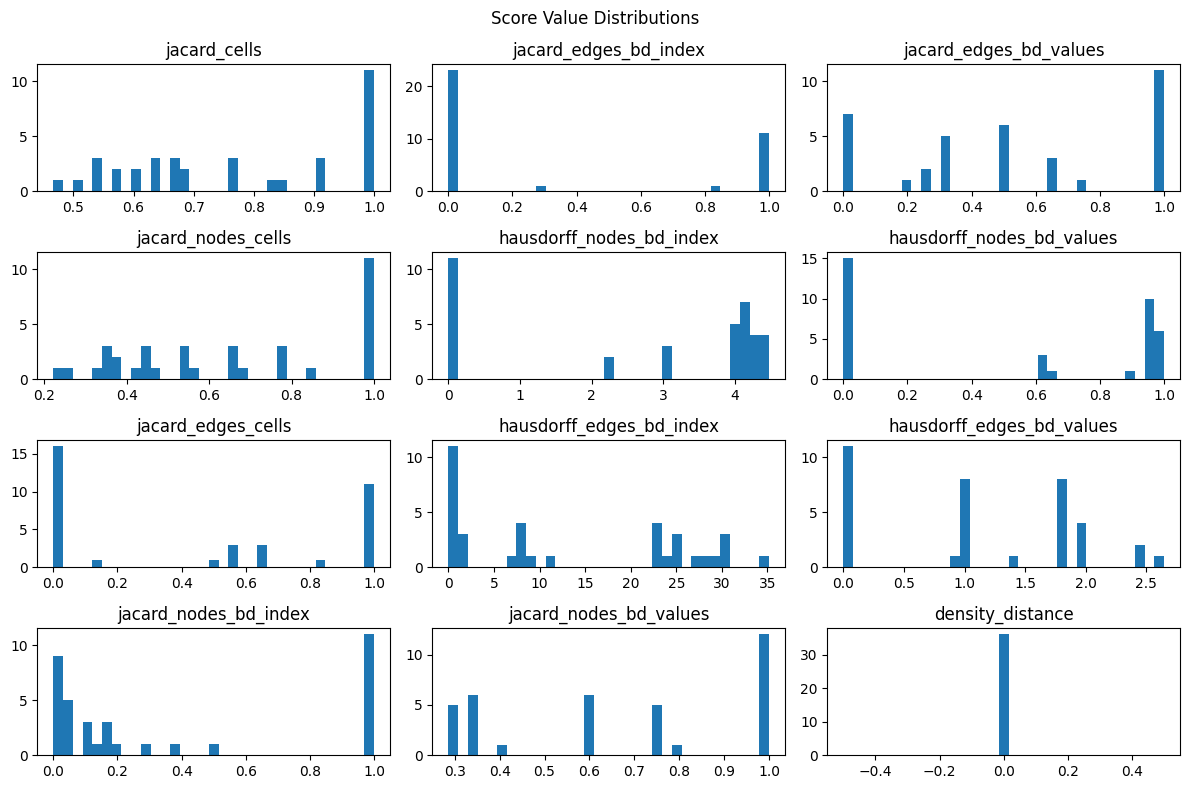

In [ ]:
n_rows = int(np.ceil(0.3*df_score_values.shape[1]))
n_cols = int(np.ceil(df_score_values.shape[1]/n_rows))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*2))
fig.suptitle('Score Value Distributions')

for i in range(n_rows*n_cols):
    i_row = i%n_rows
    i_col = i//n_rows
    if i < df_score_values.shape[1]:
        col = df_score_values.columns[i]
        axs[i_row, i_col].set_title(col)
        axs[i_row, i_col].hist(df_score_values[col], bins=len(simplices))
    else:
        axs[i_row, i_col].set_xticks([])
        axs[i_row, i_col].set_yticks([])
plt.tight_layout()
plt.show()

### Comparing Distances and Scores

In [ ]:
df_distance_score_pearson = []
for distance in df_distances.columns:
    for score in df_score_values.columns:
        corr, p_value = stats.pearsonr(df_distances[distance], df_score_values[score])
        df_distance_score_pearson.append({'distance': distance, 
                                          'score': score, 
                                          'correlation': corr, 
                                          'p-value': p_value,
                                         })

df_distance_score_pearson = pd.DataFrame(df_distance_score_pearson)
df_distance_score_pearson = df_distance_score_pearson.pivot(index='score', columns='distance', values=['correlation', 'p-value'])

print(f'df_distance_score_pearson.shape = {df_distance_score_pearson.shape}')
df_distance_score_pearson

df_distance_score_pearson.shape = (12, 6)


/tmp/ipykernel_52438/1539608274.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = stats.pearsonr(df_distances[distance], df_score_values[score])


correlation                                p-value  \
distance                    Eucledean   Hamming Transpositions     Eucledean   
score                                                                          
density_distance                  NaN       NaN            NaN           NaN   
hausdorff_edges_bd_index     0.765000  0.606692       0.536986  5.545853e-08   
hausdorff_edges_bd_values    0.865193  0.736068       0.650202  9.985473e-12   
hausdorff_nodes_bd_index     0.924727  0.873072       0.776506  7.982221e-16   
hausdorff_nodes_bd_values    0.880215  0.951229       0.907536  1.511256e-12   
jacard_cells                -0.981419 -0.958393      -0.891033  5.802066e-26   
jacard_edges_bd_index       -0.867585 -0.830289      -0.733942  7.507437e-12   
jacard_edges_bd_values      -0.884894 -0.804310      -0.672734  7.968976e-13   
jacard_edges_cells          -0.835148 -0.729545      -0.602613  2.394123e-10   
jacard_nodes_bd_index       -0.869270 -0.816744      -0.703980  6.120889e-12   
jacard_nodes_bd_values      -0.862121 -0.861519      -0.747061  1.428715e-11   
jacard_nodes_cells          -0.919554 -0.840064      -0.751381  2.372861e-15   

                                                        
distance                        Hamming Transpositions  
score                                                   
density_distance                    NaN            NaN  
hausdorff_edges_bd_index   8.761425e-05   7.336838e-04  
hausdorff_edges_bd_values  3.121700e-07   1.769223e-05  
hausdorff_nodes_bd_index   3.821062e-12   2.602482e-08  
hausdorff_nodes_bd_values  6.130188e-19   2.302238e-14  
jacard_cells               4.349716e-20   3.295550e-13  
jacard_edges_bd_index      3.770332e-10   3.513335e-07  
jacard_edges_bd_values     3.429114e-09   6.968835e-06  
jacard_edges_cells         4.470641e-07   1.005875e-04  
jacard_nodes_bd_index      1.244683e-09   1.664391e-06  
jacard_nodes_bd_values     1.531132e-11   1.663595e-07  
jacard_nodes_cells         1.489459e-10   1.287768e-07

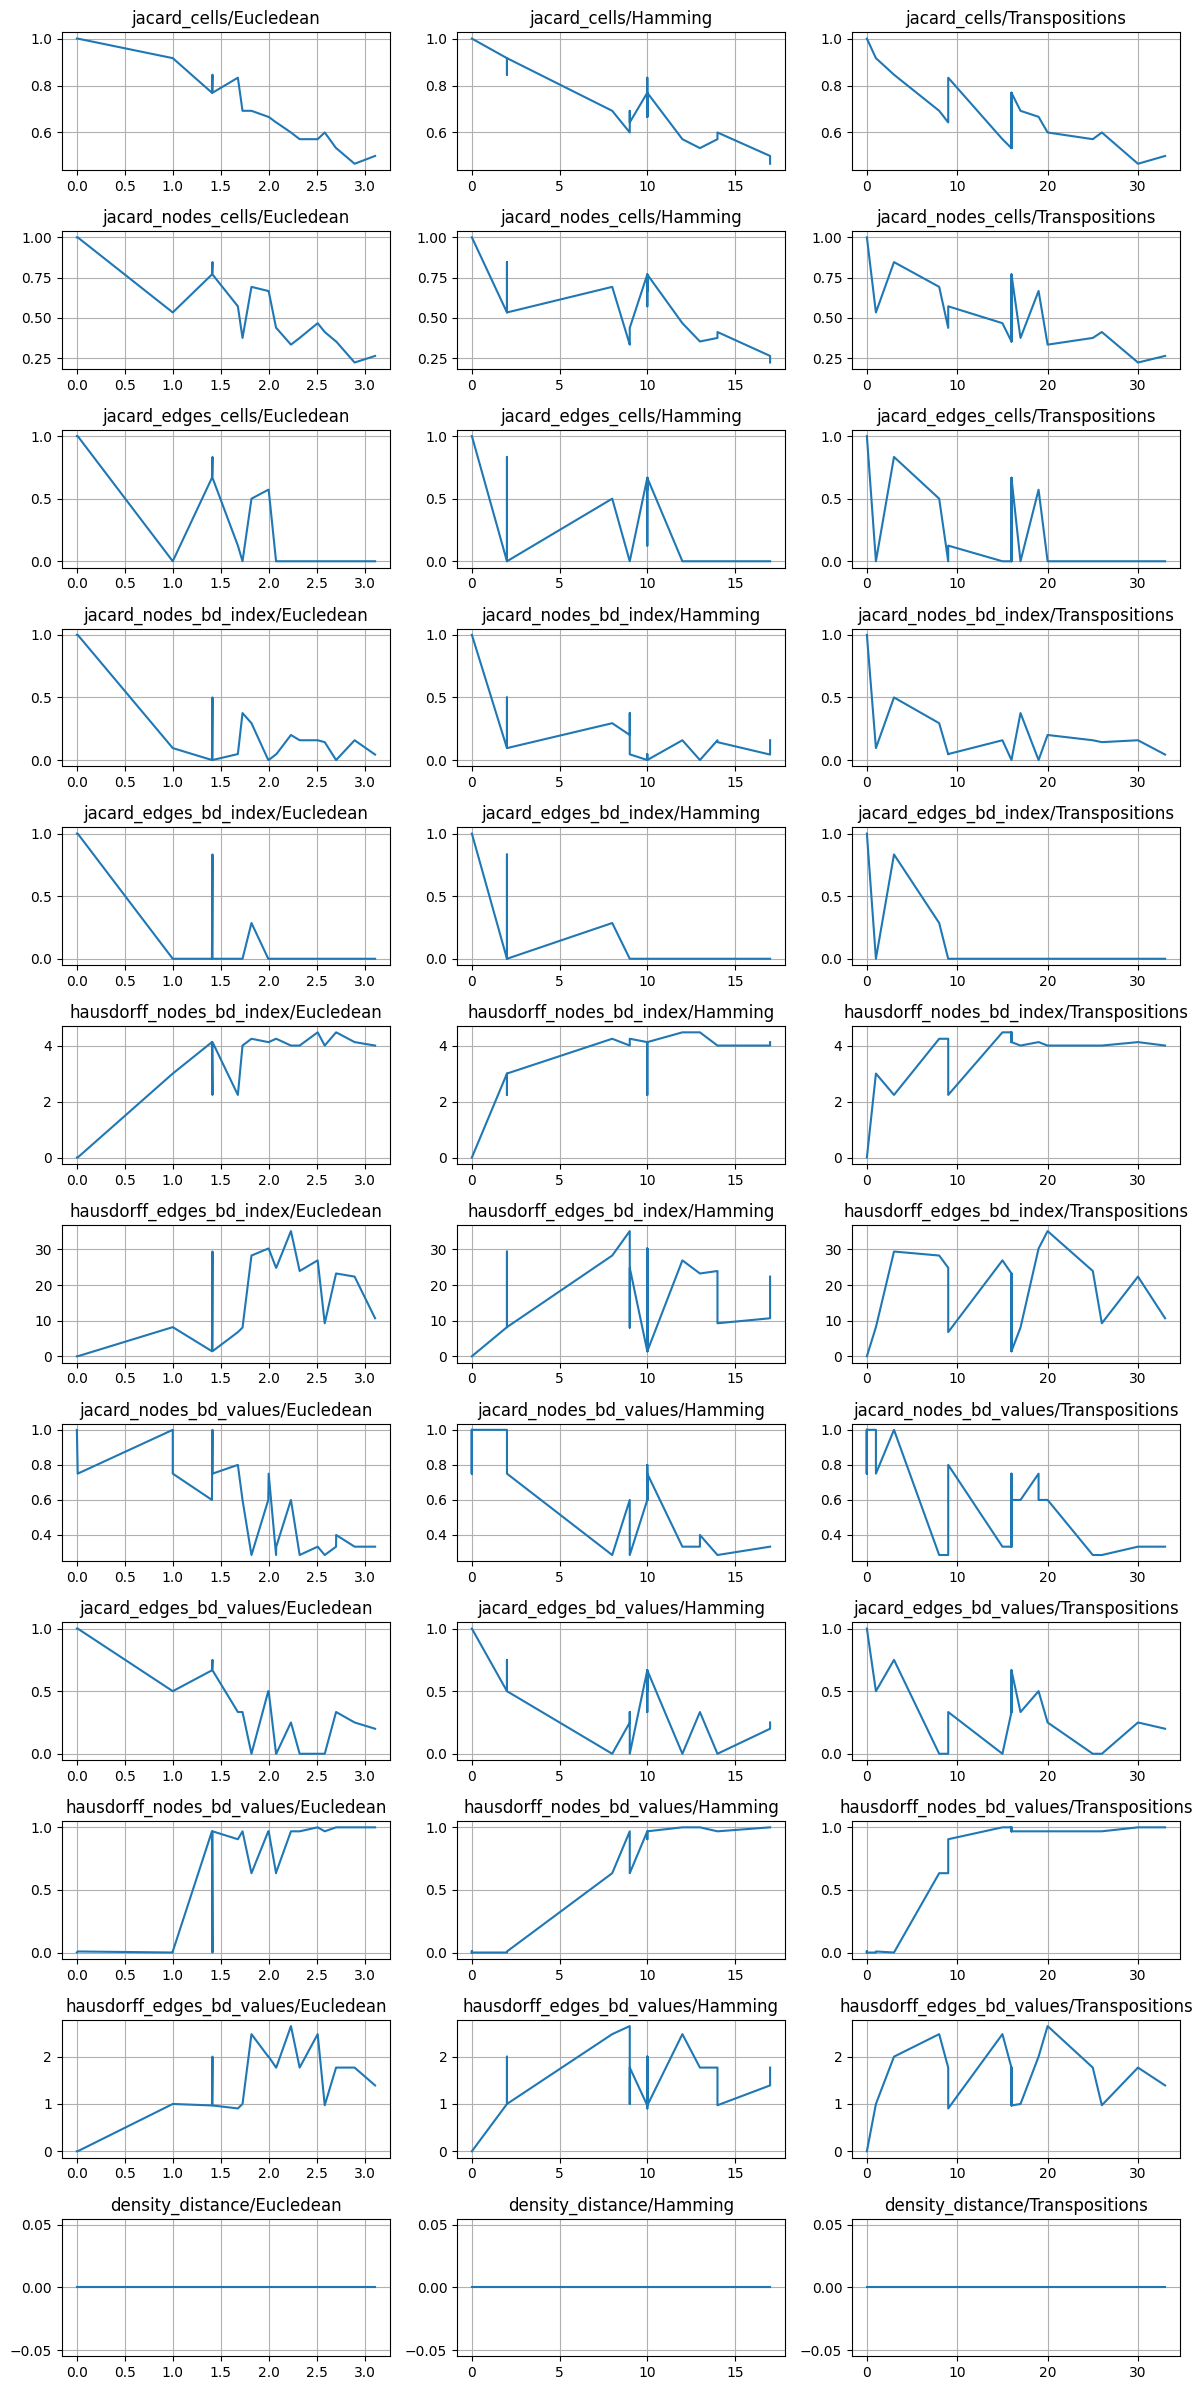

In [ ]:
fig, axs = plt.subplots(df_score_values.shape[1], df_distances.shape[1], figsize=(4*df_distances.shape[1], 2*df_score_values.shape[1]))

for i_score, score in enumerate(df_score_values.columns):
    for i_distance, distance in enumerate(df_distances.columns):
        axs[i_score, i_distance].set_title(f'{score}/{distance}')

        x = np.sort(df_distances[distance].values)
        y = df_score_values[score].values[df_distances[distance].values.argsort()]
        axs[i_score, i_distance].plot(x, y)
        axs[i_score, i_distance].grid(True)
plt.tight_layout()
plt.show()

# Homotopy Between 2 Filtrations 

In [ ]:
def assign_filtration(stree: gh.SimplexTree, filtration):
    # returns the SimplexTree with the given filtration
    stree_res = gh.SimplexTree()
    for (simplex, _), value in zip(stree.get_simplices(), filtration):
        stree_res.insert(simplex, value)
    return stree_res

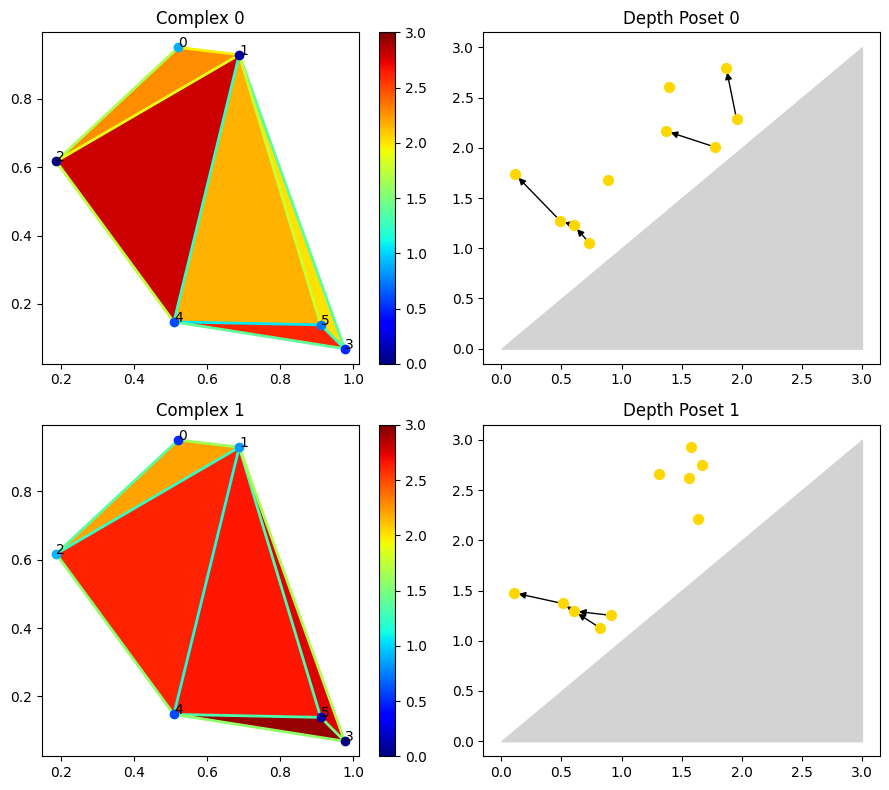

In [ ]:
n = 6
dim = 2
points = np.random.random([n, dim])

stree0 = gh.AlphaComplex(points).create_simplex_tree()
simplex_dimensions = np.array([len(simplex) - 1 for simplex, _ in stree0.get_simplices()])

filtration0 = np.random.random(len(list(stree0.get_simplices()))) + simplex_dimensions
filtration1 = np.random.random(len(list(stree0.get_simplices()))) + simplex_dimensions

stree0 = assign_filtration(stree0, filtration0)
stree1 = assign_filtration(stree0, filtration1)

cmap = 'jet'

fig, axs = plt.subplots(2, 2, figsize=(9, 8))
for i, streei in enumerate([stree0, stree1]):
    axs[i, 0].set_title(f'Complex {i}')
    sm = plot_filtred_complex2d(streei, points, ax=axs[i, 0], cmap=cmap, vmin=0, vmax=dim+1)
    plt.colorbar(sm, ax=axs[i, 0])
    enumerate_points(points, ax=axs[i, 0])

    axs[i, 1].set_title(f'Depth Poset {i}')
    dp = DepthPoset.from_simplex_tree(streei)
    nx.draw_networkx(dp.get_transitive_reduction(), pos=dp.persistant_layout(), ax=axs[i, 1], 
                     node_color='gold', node_size=50, with_labels=False, hide_ticks=False)
    axs[i, 1].fill_between([0, dim + 1], [0, 0], [0, dim + 1], color='lightgrey')

plt.tight_layout()
plt.show()

## Generate gif

In [ ]:
ts = np.linspace(0, 1, 201)
cmap = plt.get_cmap('jet')

imgs = []
for it, t in tqdm(enumerate(ts), total=len(ts)):
    filtration = (1 - t)*filtration0 + t*filtration1
    stree = assign_filtration(stree0, filtration)
    dp = DepthPoset.from_simplex_tree(stree)

    birth_colors = cmap([stree.filtration(node.source[0])/(dim + 1) for node in dp.nodes])
    death_colors = cmap([stree.filtration(node.source[1])/(dim + 1) for node in dp.nodes])


    fig, axs = plt.subplots(1, 2, figsize=(10, 5.5))
    fig.suptitle(f'$t = {t:.4f}$')

    axs[0].set_title(f'Filtration on Complex')
    sm = plot_filtred_complex2d(stree, points, ax=axs[0], cmap=cmap, vmin=0, vmax=dim+1)
    plt.colorbar(sm, ax=axs[0])
    enumerate_points(points, ax=axs[0])
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    axs[1].set_title(f'Depth Poset')
    graph = dp.get_transitive_reduction()
    pos = dp.persistant_layout()
    hide_ticks = False
    node_size = 60
    nx.draw_networkx_edges(graph, pos=pos, ax=axs[1], node_size=node_size, hide_ticks=hide_ticks)
    nx.draw_networkx_nodes(graph, pos, node_shape='o', node_color=death_colors, node_size=node_size, hide_ticks=hide_ticks)
    nx.draw_networkx_nodes(graph, pos, node_shape='*', node_color=birth_colors, node_size=node_size, hide_ticks=hide_ticks)
    
    axs[1].fill_between([0, dim + 1], [0, 0], [0, dim + 1], color='lightgrey')

    handles = [Line2D([], [], marker='*', color='w', label='Birth', markerfacecolor='black', markersize=12), 
               Line2D([], [], marker='o', color='w', label='Death', markerfacecolor='black', markersize=8)]
    axs[1].legend(handles=handles, loc='lower right',  bbox_to_anchor=(0.9, 0.1))

    plt.tight_layout()

    # draw, save, close and delete
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8').reshape(height, width, 4)
    img = Image.fromarray(image[..., :3])  
    
    imgs.append(img)
    plt.close('all')
    del fig

filename = f'gifs/2-filtrations-homotopy.gif'

io.mimsave(filename, imgs, fps=12, loop=0)
print(f'generated and saved to path {filename}')

  0%|          | 0/201 [00:00<?, ?it/s]

generated and saved to path gifs/2-filtrations-homotopy.gif


## Transposition Classification Functions

In [ ]:
def get_xyab_bb(transposition, dp0: DepthPoset):
    # Returns x, y, a, b indices for birth-birth case
    if transposition['type'] != 'birth-birth':
        return None
    for node in dp0.nodes:
        if node.birth_index == transposition['index 0']:
            a = node.birth_index
            b = node.death_index
        if node.birth_index == transposition['index 1']:
            x = node.birth_index
            y = node.death_index
    return x, y, a, b

def get_xyab_dd(transposition, dp0: DepthPoset):
    # Returns x, y, a, b indices for death-death case
    if transposition['type'] != 'death-death':
        return None
    for node in dp0.nodes:
        if node.death_index == transposition['index 0']:
            x = node.birth_index
            y = node.death_index
        if node.death_index == transposition['index 1']:
            a = node.birth_index
            b = node.death_index
    return x, y, a, b

def get_xyab_bd(transposition, dp0: DepthPoset):
    # Returns x, y, a, b indices for birth-death case
    if transposition['type'] != 'birth-death':
        return None
    for node in dp0.nodes:
        if node.death_index == transposition['index 0']:
            a = node.birth_index
            b = node.death_index
        if node.death_index == transposition['index 1']:
            a = node.birth_index
            b = node.death_index
        if node.birth_index == transposition['index 0']:
            x = node.birth_index
            y = node.death_index
        if node.birth_index == transposition['index 1']:
            x = node.birth_index
            y = node.death_index
    return x, y, a, b
    
def get_xyab(transposition, dp0: DepthPoset):
    # 
    try:
        if transposition['type'] == 'birth-birth':
            return get_xyab_bb(transposition, dp0)
        if transposition['type'] == 'death-death':
            return get_xyab_dd(transposition, dp0)
        if transposition['type'] == 'birth-death':
            return get_xyab_bd(transposition, dp0)
    except UnboundLocalError:
        return None

In [ ]:
def _get_transposition_relations_and_classifying_matrix_stree(stree0: gh.SimplexTree, dp0: DepthPoset, transposition, reduce_matrix=True):
    # 
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    try:
        x, y, a, b = get_xyab(transposition, dp0)
    except TypeError:
        return None, None, None

    stop_condition = lambda alpha, b0, delta: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + \
                                              len({(a, x), (x, a), (b, y), (y, b)} & set(b0)) > 0
    if transposition['type'] == 'birth-birth':
        #stop_condition = lambda alpha, b0, delta0: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + len({(b, y), (y, b)} & set (b0)) != 0
        alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
        if reduce_matrix:
            return list(alpha.values()), b0, tuple(map(tuple, delta0[np.sort([x, a])][:, np.sort([y, b])]))
        else:
            return list(alpha.values()), b0, delta0
            
    if transposition['type'] == 'death-death':
        #stop_condition = lambda omega, b1, delta1: len({(a, b), (a, y), (x, b), (x, y)} & set(omega.values())) + len({(a, x), (x, a)} & set (b1)) != 0
        omega, b1, delta1 = depth.reduct_row_left_to_right(border_matrix0, stop_condition)
        if reduce_matrix:
            return list(omega.values()), b1, tuple(map(tuple, delta1[np.sort([x, a])][:, np.sort([y, b])]))
        else:
            return list(omega.values()), b1, delta1
        
    if transposition['type'] == 'birth-death':
        #stop_condition = lambda alpha, b0, delta0: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + len({(b, y), (y, b)} & set (b0)) != 0
        alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
        #stop_condition = lambda omega, b1, delta1: len({(a, b), (a, y), (x, b), (x, y)} & set(omega.values())) + len({(a, x), (x, a)} & set (b1)) != 0
        omega, b1, delta1 = depth.reduct_row_left_to_right(delta0, stop_condition)
        if reduce_matrix:
            return list(alpha.values()) + list(omega.values()), b0 + b1, tuple(map(tuple, delta1[np.sort([a, b, x, y])][:, np.sort([a, b, x, y])]))
        else:
            return list(alpha.values()) + list(omega.values()), b0 + b1, delta1


def _get_transposition_relations_and_classifying_matrix_bm(border_matrix0: np.ndarray, dp0: DepthPoset, transposition, reduce_matrix=True, order0=None):
    # 
    if order0 is None:
        order0 = np.arange(len(border_matrix0))
    try:
        x, y, a, b = get_xyab(transposition, dp0)
    except TypeError:
        return None, None, None

    stop_condition = lambda alpha, b0, delta: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + \
                                              len({(a, x), (x, a), (b, y), (y, b)} & set(b0)) > 0
    if transposition['type'] == 'birth-birth':
        #stop_condition = lambda alpha, b0, delta0: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + len({(b, y), (y, b)} & set (b0)) != 0
        alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
        if reduce_matrix:
            return list(alpha.values()), b0, tuple(map(tuple, delta0[np.sort([x, a])][:, np.sort([y, b])]))
        else:
            return list(alpha.values()), b0, delta0
            
    if transposition['type'] == 'death-death':
        #stop_condition = lambda omega, b1, delta1: len({(a, b), (a, y), (x, b), (x, y)} & set(omega.values())) + len({(a, x), (x, a)} & set (b1)) != 0
        omega, b1, delta1 = depth.reduct_row_left_to_right(border_matrix0, stop_condition)
        if reduce_matrix:
            return list(omega.values()), b1, tuple(map(tuple, delta1[np.sort([x, a])][:, np.sort([y, b])]))
        else:
            return list(omega.values()), b1, delta1
        
    if transposition['type'] == 'birth-death':
        #stop_condition = lambda alpha, b0, delta0: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + len({(b, y), (y, b)} & set (b0)) != 0
        alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
        #stop_condition = lambda omega, b1, delta1: len({(a, b), (a, y), (x, b), (x, y)} & set(omega.values())) + len({(a, x), (x, a)} & set (b1)) != 0
        omega, b1, delta1 = depth.reduct_row_left_to_right(delta0, stop_condition)
        if reduce_matrix:
            return list(alpha.values()) + list(omega.values()), b0 + b1, tuple(map(tuple, delta1[np.sort([a, b, x, y])][:, np.sort([a, b, x, y])]))
        else:
            return list(alpha.values()) + list(omega.values()), b0 + b1, delta1

def get_transposition_relations_and_classifying_matrix(arg, dp0: DepthPoset, transposition, reduce_matrix=True, order=None):
    # 
    if isinstance(arg, gh.SimplexTree):
        return _get_transposition_relations_and_classifying_matrix_stree(arg, dp0, transposition, reduce_matrix)
    if isinstance(arg, np.ndarray):
        return _get_transposition_relations_and_classifying_matrix_bm(arg, dp0, transposition, reduce_matrix, order)

In [ ]:
def _get_switch_type_stree(stree0: gh.SimplexTree, dp0: DepthPoset, transposition):
    # 
    alpha, omega, matrix = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition, reduce_matrix=True)

    if transposition['type'] == 'birth-birth':
        if matrix == ((1, 1), 
                      (1, 0)):
            return "switch forward"
        if matrix == ((1, 0), 
                      (1, 1)):
            return "switch backward"
    if transposition['type'] == 'death-death':
        if matrix == ((0, 1), 
                      (1, 1)):
            return "switch forward"
        if matrix == ((1, 0), 
                      (1, 1)):
            return "switch backward"
    if transposition['type'] == 'birth-death':
        if matrix == ((0, 1, 1, 0), 
                      (0, 0, 0, 1), 
                      (0, 0, 0, 1), 
                      (0, 0, 0, 0)):
            return "switch forward"
    return 'no switch'

def _get_switch_type_bm(border_matrix: np.ndarray, dp0: DepthPoset, transposition, order=None):
    # 
    alpha, omega, matrix = get_transposition_relations_and_classifying_matrix(border_matrix, dp0, transposition, reduce_matrix=True, order=order)

    if transposition['type'] == 'birth-birth':
        if matrix == ((1, 1), 
                      (1, 0)):
            return "switch forward"
        if matrix == ((1, 0), 
                      (1, 1)):
            return "switch backward"
    if transposition['type'] == 'death-death':
        if matrix == ((0, 1), 
                      (1, 1)):
            return "switch forward"
        if matrix == ((1, 0), 
                      (1, 1)):
            return "switch backward"
    if transposition['type'] == 'birth-death':
        if matrix == ((0, 1, 1, 0), 
                      (0, 0, 0, 1), 
                      (0, 0, 0, 1), 
                      (0, 0, 0, 0)):
            return "switch forward"
    return 'no switch'

def get_switch_type(arg, dp0: DepthPoset, transposition, order=None):
    # 
    if isinstance(arg, gh.SimplexTree):
        return _get_switch_type_stree(arg, dp0, transposition)
    if isinstance(arg, np.ndarray):
        return _get_switch_type_bm(arg, dp0, transposition, order=order)

In [ ]:
def define_transposition_type(stree_before: gh.SimplexTree, simplex0: tuple, simplex1: tuple, dp_before: DepthPoset=None):
    """
    """
    order, border_matrix = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    order = np.array(order, dtype=object)
    idx0 = np.where([simplex == simplex0 for simplex in order])[0][0]
    idx1 = np.where([simplex == simplex1 for simplex in order])[0][0]
    #if abs(idx0 - idx1) != 1:
    #    return None

    if dp_before is None:
        dp_before = DepthPoset.from_simplex_tree(stree_before)
    birth_simplices = [node.source[0] for node in dp_before.nodes]
    death_simplices = [node.source[1] for node in dp_before.nodes]
    if simplex0 in birth_simplices and simplex1 in birth_simplices:
        return 'birth-birth'
    if simplex0 in death_simplices and simplex1 in death_simplices:
        return 'death-death'
    if simplex0 in birth_simplices and simplex1 in death_simplices:
        return 'birth-death'
    if simplex1 in birth_simplices and simplex0 in death_simplices:
        return 'birth-death'
        
def define_transposition_switch(stree_before: gh.SimplexTree, simplex0: tuple, simplex1: tuple, dp_before: DepthPoset=None):
    """
    """
    if dp_before is None:
        dp_before = DepthPoset.from_simplex_tree(stree_before)

    transposition_type = define_transposition_type(stree_before, simplex0, simplex1, dp_before)
    if transposition_type is None:
        return 'no switch'
    
    order, border_matrix = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    order = np.array(order, dtype=object)
    idx0 = np.where([simplex == simplex0 for simplex in order])[0][0]
    idx1 = np.where([simplex == simplex1 for simplex in order])[0][0]

    if idx0 > idx1:
        simplex0, simplex1 = simplex1, simplex0
        idx0, idx1 = idx1, idx0

    transposition = {'index 0': idx0, 
                     'index 1': idx1,
                     'type': transposition_type,
                     }
    return get_switch_type(stree_before, dp_before, transposition, order=order)



In [ ]:
define_transposition_type(stree0, (4, ), (0, )), define_transposition_switch(stree0, (4, ), (0, )), 

('birth-birth', 'no switch')

## Classifying Transpositions

In [ ]:
def get_cross_parameters(y0, y1, t0=0, t1=1, filter_outside=True):
    """
    Returns the matrix of cross parameters between two arrays.

    Parameters:
        y0, y1: two arrays of the same length
        t0, t1: the time points for the arrays
        filter_outside: if True, filter out the values outside the range [t0, t1]

    Returns:
        cross_parameters: the matrix of cross parameters
    """
    y0 = np.asarray(y0)
    y1 = np.asarray(y1)
    if y0.shape != y1.shape:
        raise ValueError("Arrays must have the same length.")
    if y0.ndim != 1:
        raise ValueError("Arrays must be 1D.")
    
    yi0 = y0.reshape(-1, 1)
    yi1 = y1.reshape(-1, 1)
    yj0 = y0.reshape(1, -1)
    yj1 = y1.reshape(1, -1)

    cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


    if filter_outside:
        cross_parameters[cross_parameters < min(t0, t1)] = np.nan
        cross_parameters[cross_parameters > max(t0, t1)] = np.nan
    return cross_parameters

In [ ]:
def depth_posets_changes(dp0: DepthPoset, dp1: DepthPoset) -> bool:
    # returns True if Depth Posets are different
    g0 = set([node.source for node in dp0.nodes]) == set([node.source for node in dp1.nodes])
    g1 = set([(e0.source, e1.source) for e0, e1 in dp0.edges]) == set([(e0.source, e1.source) for e0, e1 in dp1.edges])
    return  not (g0 and g1)

In [ ]:
simplices = np.array([tuple(simplex) for simplex, _ in stree0.get_simplices()], dtype=object)
dims = np.array([len(simplex) - 1 for simplex in simplices])

cross_parameters = [get_cross_parameters(filtration0[dims == dim], filtration1[dims == dim]) for dim in range(3)]

eps = 0.8*min([min(np.unique(np.triu(i))[1:-1] - np.unique(np.triu(i))[:-2]) for i in cross_parameters])

df_transpositions = []
for dim in range(3):
    for i, j in np.argwhere(~np.isnan(cross_parameters[dim])):
        simplex_i, simplex_j = simplices[dims == dim][[i, j]]



        time = cross_parameters[dim][i, j]
        value = (1 - time)*filtration0[dims == dim][i] + time*filtration1[dims == dim][i]

        t_before = time - eps
        filtration_before = (1 - t_before)*filtration0 + t_before*filtration1
        stree_before = assign_filtration(stree, filtration_before)
        dp_before = DepthPoset.from_simplex_tree(stree_before)

        t_after = time + eps
        filtration_after = (1 - t_after)*filtration0 + t_after*filtration1
        stree_after = assign_filtration(stree, filtration_after)
        dp_after = DepthPoset.from_simplex_tree(stree_after)

        transposition_type = define_transposition_type(stree_before, simplex0=simplex_i, simplex1=simplex_j)
        transposition_switch = define_transposition_switch(stree_before, simplex0=simplex_i, simplex1=simplex_j)
        if i < j:
            df_transpositions.append({
                'dim': dim, 
                'simplex 0': simplex_i, 
                'simplex 1': simplex_j, 
                'time': time, 
                'value': value, 
                'type': transposition_type, 
                'switch': transposition_switch, 
                'changing': depth_posets_changes(dp_before, dp_after),
            })

df_transpositions = pd.DataFrame(df_transpositions)


print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

/tmp/ipykernel_59081/49407725.py:25: RuntimeWarning: invalid value encountered in divide
  cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


df_transpositions.shape = (38, 8)


,dim,simplex 0,simplex 1,time,value,type,switch,changing
0,0,"(0,)","(1,)",0.711070,0.617780,birth-birth,no switch,True
1,0,"(0,)","(2,)",0.679378,0.629714,birth-birth,no switch,True
2,0,"(0,)","(4,)",0.748729,0.603600,birth-birth,no switch,True
3,0,"(1,)","(2,)",0.473877,0.449786,birth-birth,no switch,True
4,0,"(1,)","(3,)",0.315118,0.337343,birth-birth,switch forward,True


In [ ]:
df_transpositions[['type', 'switch', 'changing']].value_counts(dropna=False)

type         switch           changing
birth-birth  no switch        True        8
birth-death  no switch        False       8
birth-birth  no switch        False       5
death-death  no switch        True        5
                              False       3
birth-death  no switch        True        2
birth-birth  switch forward   True        2
death-death  switch forward   True        2
birth-birth  switch forward   False       1
death-death  switch backward  False       1
NaN          no switch        True        1
Name: count, dtype: int64

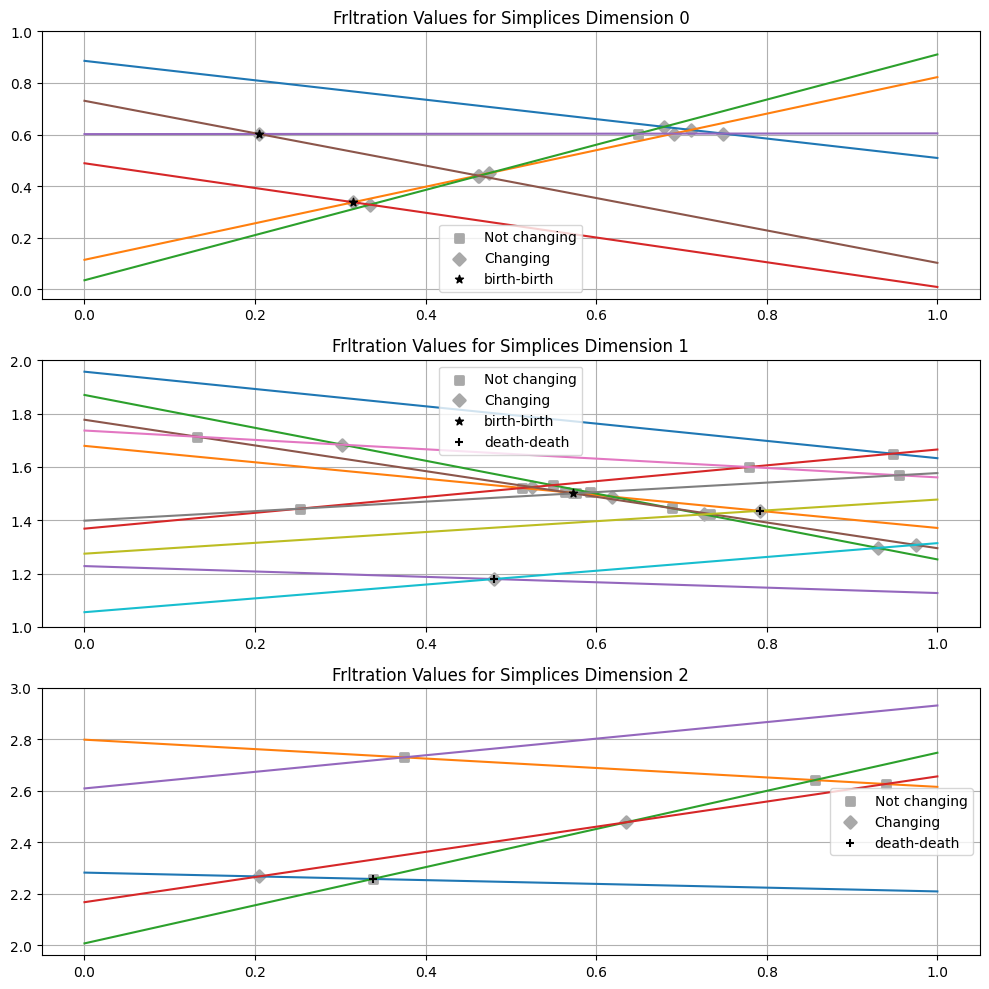

In [ ]:
fig, axs = plt.subplots(3, figsize=[10, 10])

for dim in range(3):
    axs[dim].set_title(f'Frltration Values for Simplices Dimension {dim}')
    for simplex, y0, y1 in zip(simplices[dims == dim], filtration0[dims == dim], filtration1[dims == dim]):
        axs[dim].plot([0, 1], [y0, y1])
    
    x = df_transpositions[(df_transpositions['dim'] == dim)&~df_transpositions['changing']]['time']
    y = df_transpositions[(df_transpositions['dim'] == dim)&~df_transpositions['changing']]['value']
    if len(x) > 0:
        axs[dim].scatter(x, y, color='darkgrey', marker='s', label='Not changing', linewidth=2)

    x = df_transpositions[(df_transpositions['dim'] == dim)&df_transpositions['changing']]['time']
    y = df_transpositions[(df_transpositions['dim'] == dim)&df_transpositions['changing']]['value']
    if len(x) > 0:
        axs[dim].scatter(x, y, color='darkgrey', marker='D', label='Changing', linewidth=2)


    for transposition_type, marker in zip(['birth-birth', 'death-death', 'birth-death'], '*+o'):
        dfi = df_transpositions[(df_transpositions['dim'] == dim) & 
                                (df_transpositions['type'] == transposition_type) & 
                                df_transpositions['switch'].isin(['switch forward', 'switch backward'])]
        x = dfi['time']
        y = dfi['value']
        if len(x) > 0:
            axs[dim].scatter(x, y, marker=marker, color='black', zorder=2, label=transposition_type)
    
    axs[dim].set_yticks(np.linspace(dim, dim + 1, 6))
    axs[dim].grid(True)
    axs[dim].legend()


plt.tight_layout()
plt.show()

### Changing no-switch transpositions

In [ ]:
df_changing_noswitch = df_transpositions[df_transpositions['changing']&(df_transpositions['switch'] == 'no switch')]

print(f'df_changing_noswitch.shape = {df_changing_noswitch.shape}')
df_changing_noswitch.head()

df_changing_noswitch.shape = (16, 8)


,dim,simplex 0,simplex 1,time,value,type,switch,changing
0,0,"(0,)","(1,)",0.711070,0.617780,birth-birth,no switch,True
1,0,"(0,)","(2,)",0.679378,0.629714,birth-birth,no switch,True
2,0,"(0,)","(4,)",0.748729,0.603600,birth-birth,no switch,True
3,0,"(1,)","(2,)",0.473877,0.449786,birth-birth,no switch,True
5,0,"(1,)","(4,)",0.690820,0.603438,birth-birth,no switch,True


In [ ]:
df_changing_noswitch['type'].value_counts()

type
birth-birth    8
death-death    5
birth-death    2
Name: count, dtype: int64

In [ ]:
type_limit = 2
df_changing_noswitch = [df_changing_noswitch[df_changing_noswitch['type'] == transposition_type] for transposition_type in pd.unique(df_changing_noswitch['type'])]
df_changing_noswitch = [dfi.sample(frac=1).head(type_limit) for dfi in df_changing_noswitch]
df_changing_noswitch = pd.concat(df_changing_noswitch)

print(f'df_changing_noswitch.shape = {df_changing_noswitch.shape}')
df_changing_noswitch.head(10)

df_changing_noswitch.shape = (6, 8)


,dim,simplex 0,simplex 1,time,value,type,switch,changing
5,0,"(1,)","(4,)",0.690820,0.603438,birth-birth,no switch,True
2,0,"(0,)","(4,)",0.748729,0.603600,birth-birth,no switch,True
12,1,"(0, 2)","(1, 2)",0.618192,1.488828,death-death,no switch,True
33,2,"(0, 1, 2)","(1, 4, 5)",0.204555,2.267910,death-death,no switch,True
19,1,"(1, 2)","(2, 4)",0.302473,1.683553,birth-death,no switch,True
30,1,"(1, 5)","(4, 5)",0.974480,1.307683,birth-death,no switch,True


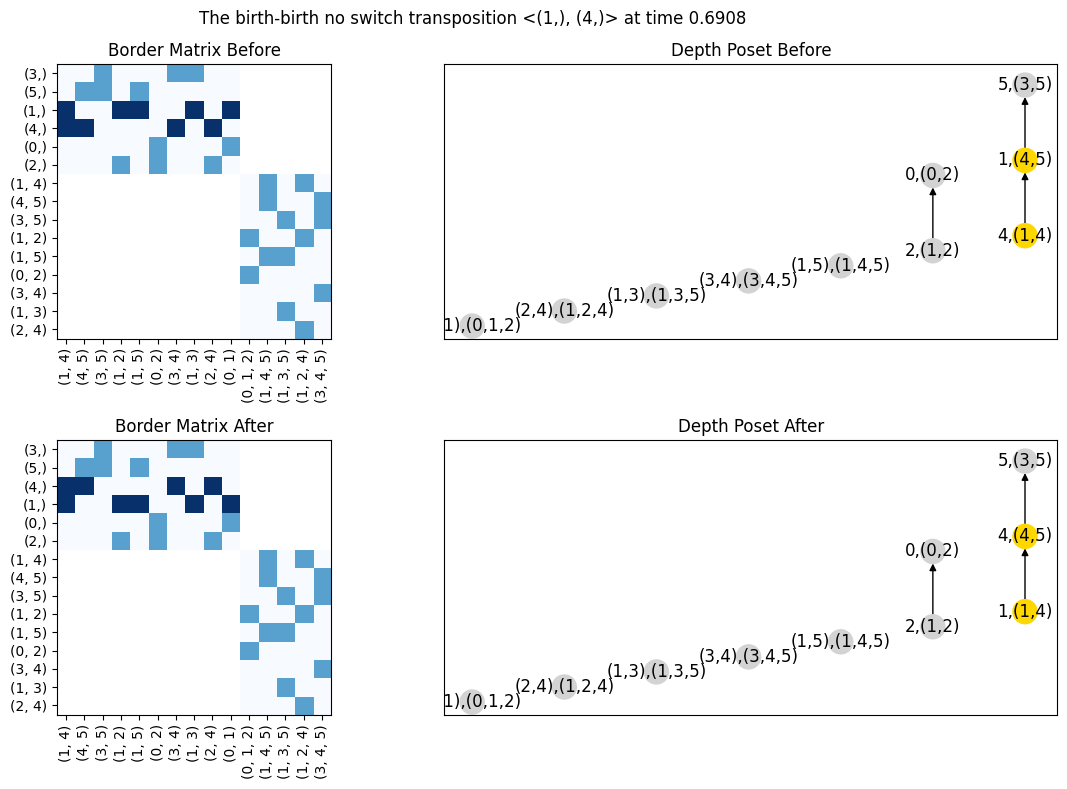

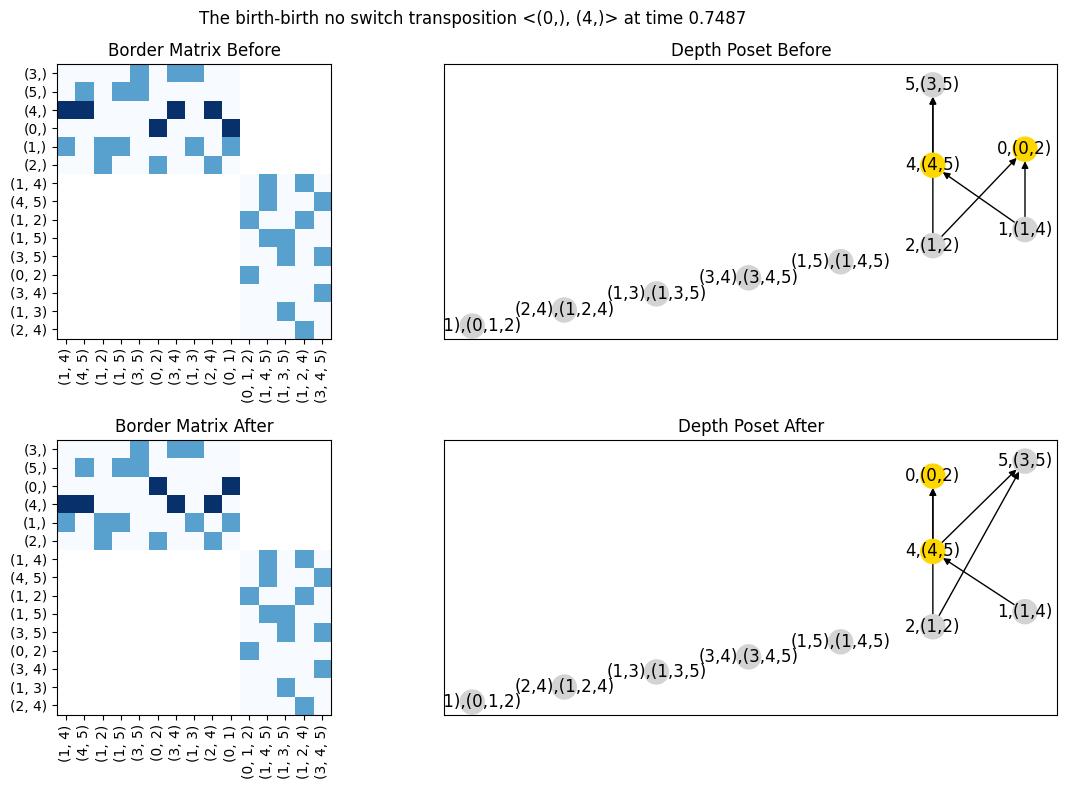

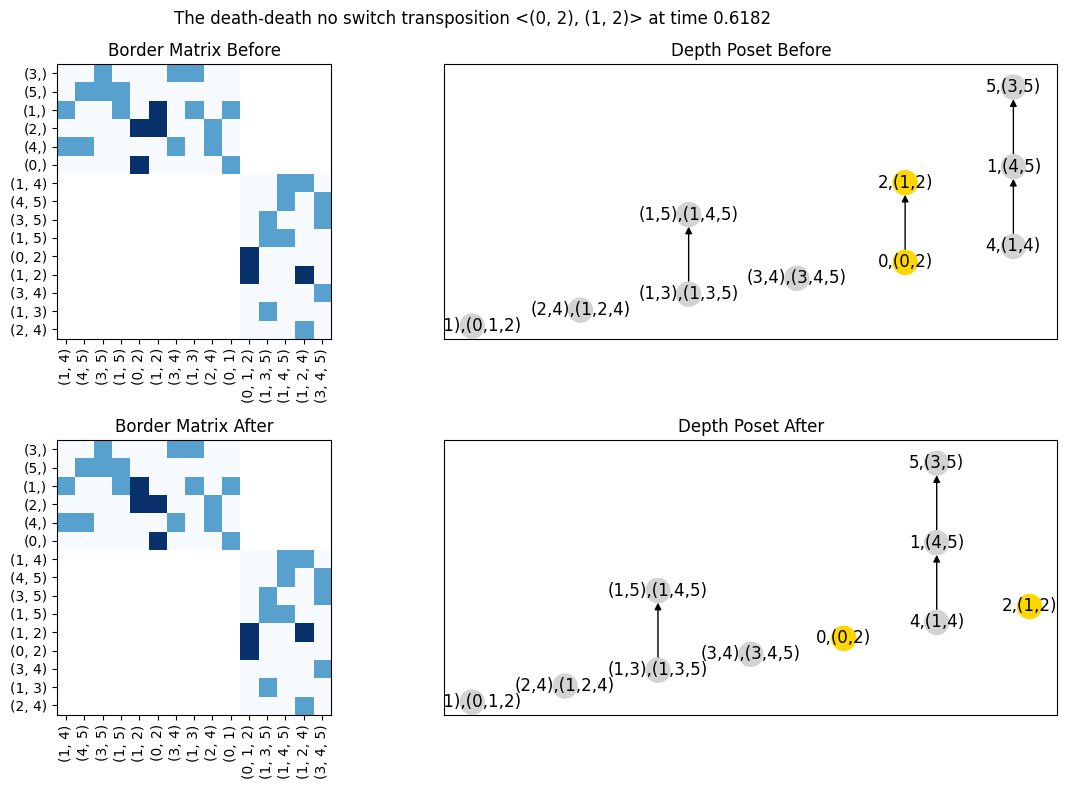

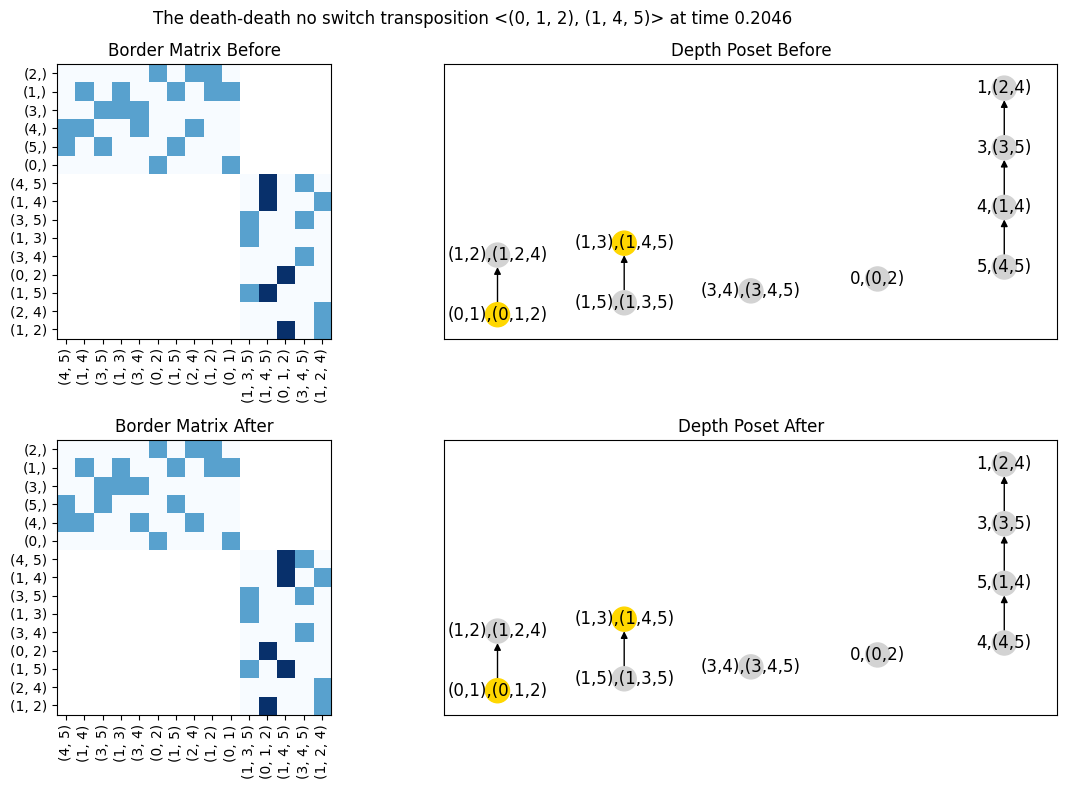

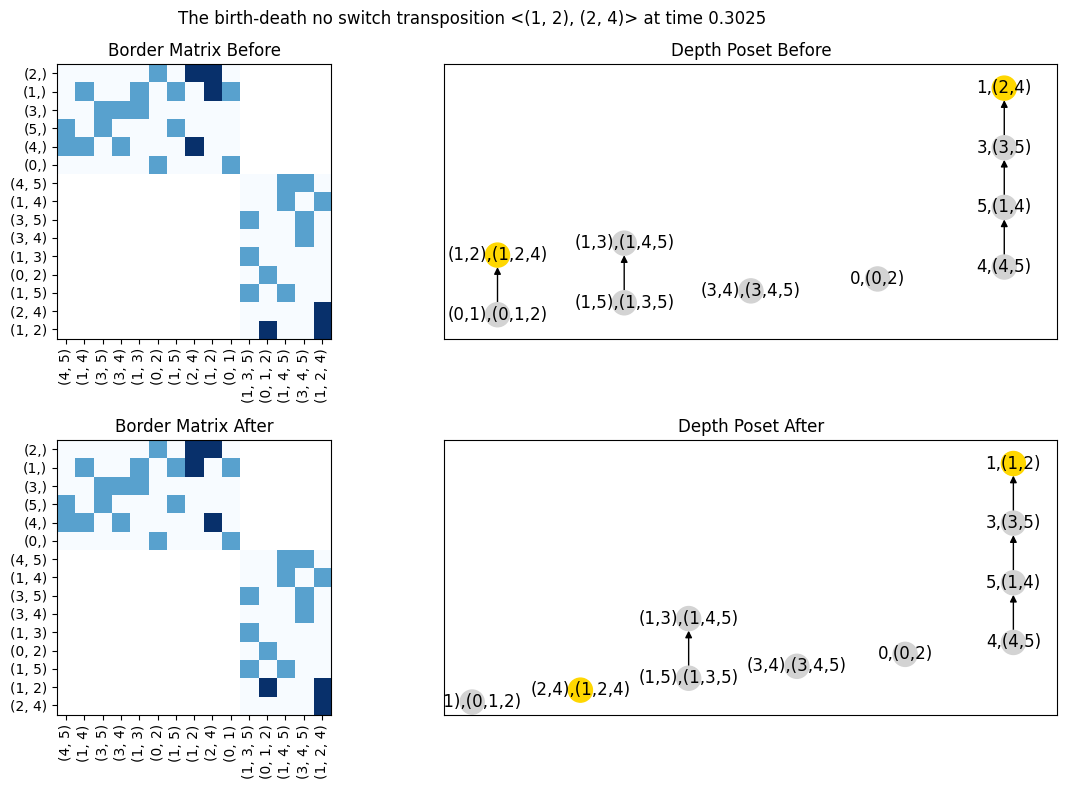

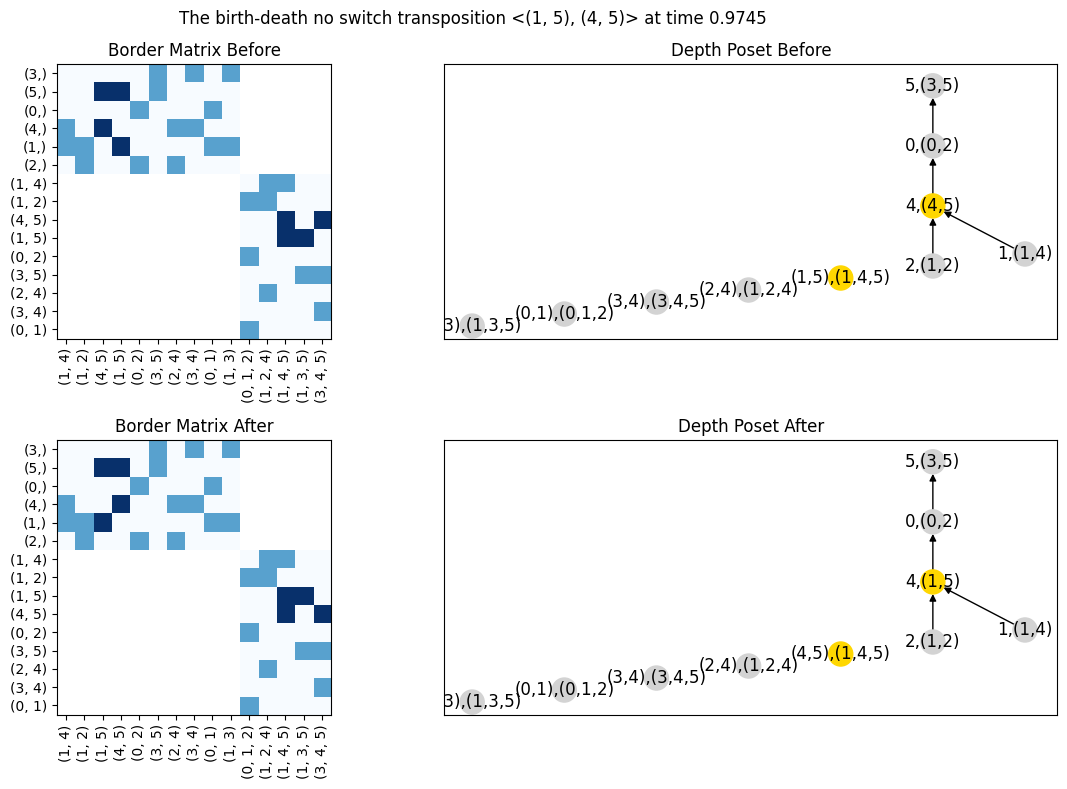

In [ ]:
for irow, row in df_changing_noswitch.iterrows():
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    title = f'The {row['type']} {row['switch']} transposition <{row['simplex 0']}, {row['simplex 1']}> at time {row['time']:.4f}'
    fig.suptitle(title)

    t_before = row['time'] - eps
    t_after = row['time'] + eps

    filtration_before = filtration0*(1 - t_before) + filtration1*t_before
    filtration_after = filtration0*(1 - t_after) + filtration1*t_after

    stree_before = assign_filtration(stree, filtration_before)
    stree_after = assign_filtration(stree, filtration_after)

    order_before, matrix_before = depth.get_ordered_border_matrix_from_simplex_tree(stree_before)
    dims_before = np.array([len(s) - 1 for s in order_before])
    matrix_before = matrix_before.astype('float')
    matrix_before[dims_before.reshape(1, -1) - dims_before.reshape(-1, 1) != 1] = np.nan
    matrix_before[[s == row['simplex 0'] or s == row['simplex 1'] for s in order_before], :] *= 1.8
    matrix_before[:, [s == row['simplex 0'] or s == row['simplex 1'] for s in order_before]] *= 1.8
    

    order_after, matrix_after = depth.get_ordered_border_matrix_from_simplex_tree(stree_after)
    dims_after = np.array([len(s) - 1 for s in order_after])
    matrix_after = matrix_after.astype('float')
    matrix_after[dims_after.reshape(1, -1) - dims_after.reshape(-1, 1) != 1] = np.nan
    matrix_after[[s == row['simplex 0'] or s == row['simplex 1'] for s in order_after], :] *= 1.8
    matrix_after[:, [s == row['simplex 0'] or s == row['simplex 1'] for s in order_after]] *= 1.8

    axs[0, 0].set_title('Border Matrix Before')
    axs[0, 0].imshow(matrix_before, cmap='Blues')
    axs[0, 0].set_xticks(np.arange(len(order_before)), order_before, rotation=90)
    axs[0, 0].set_yticks(np.arange(len(order_before)), order_before, rotation=0)
    axs[0, 0].set_xlim((dims_before == 0).sum() - 0.5, len(order_before) - 0.5)
    axs[0, 0].set_ylim((dims_before > 0).sum() - 0.5, -0.5)

    axs[1, 0].set_title('Border Matrix After')
    axs[1, 0].imshow(matrix_after, cmap='Blues')
    axs[1, 0].set_xticks(np.arange(len(order_after)), order_after, rotation=90)
    axs[1, 0].set_yticks(np.arange(len(order_after)), order_after, rotation=0)
    axs[1, 0].set_xlim((dims_after == 0).sum() - 0.5, len(order_after) - 0.5)
    axs[1, 0].set_ylim((dims_after > 0).sum() - 0.5, -0.5)

    dp_before = DepthPoset.from_simplex_tree(stree_before)#.subposet_dim(row['dim'])
    dp_after = DepthPoset.from_simplex_tree(stree_after)

    node_colors_before = ['gold' if row['simplex 0'] in node.source or row['simplex 1'] in node.source else 'lightgrey' for node in dp_before.nodes]
    node_colors_after = ['gold' if row['simplex 0'] in node.source or row['simplex 1'] in node.source else 'lightgrey' for node in dp_after.nodes]

    axs[0, 1].set_title('Depth Poset Before')
    nx.draw_networkx(dp_before.get_transitive_reduction(), pos=dp_before.hasse_layout(alignment_slope=0.2), node_color=node_colors_before, ax=axs[0, 1])

    axs[1, 1].set_title('Depth Poset After')
    nx.draw_networkx(dp_after.get_transitive_reduction(), pos=dp_after.hasse_layout(alignment_slope=0.2), node_color=node_colors_after, ax=axs[1, 1])

    plt.tight_layout()
    plt.show()

## Scores Changes During the Homotopy

In [ ]:
import inspect
from src import poset_scores

scores = [obj for name, obj in inspect.getmembers(poset_scores, inspect.isfunction)]
print('Scores:\n- ' + '\n- '.join([score.__name__ for score in scores]))

Scores:
- avarage_maximal_chain
- cycles_dimension
- height
- minimum_maximal_chain
- number_of_components
- number_of_edges_in_closure
- number_of_edges_in_reduction
- number_of_maximal_nodes
- number_of_minimal_nodes
- number_of_nodes
- number_of_relations
- width


In [ ]:
ts = np.linspace(0, 1, 201)

df = []


for it, t in tqdm(enumerate(ts), total=len(ts)):
    df.append({})

    filtration = (1 - t)*filtration0 + t*filtration1
    stree = assign_filtration(stree0, filtration)
    for simplex, value in stree.get_simplices():
        df[-1].update({(f'Simplices dim {len(simplex) - 1}', tuple(simplex)): value})

    dp = DepthPoset.from_simplex_tree(stree)
    dps = {'Full Depth Poset': dp, 
           'Subposet dim 0': dp.subposet_dim(0), 
           'Subposet dim 1': dp.subposet_dim(1)}

    for score in scores:
        for poset_name, poset in dps.items():
            try:
                value = score(poset)
            except Exception:
                value = np.nan
            df[-1].update({(score.__name__, poset_name): value})



df = pd.DataFrame(df)
df.columns = pd.MultiIndex.from_tuples(df.columns)
df.index = ts

df = df[np.concatenate([[f'Simplices dim {i}' for i in range(3)], [score.__name__ for score in scores]])]

print(f'df.shape = {df.shape}')
df.head()

  0%|          | 0/201 [00:00<?, ?it/s]

df.shape = (201, 57)


Simplices dim 0                                                    \
                 (0,)      (1,)      (2,)      (3,)      (4,)      (5,)   
0.000        0.885533  0.114158  0.034880  0.488512  0.601506  0.730642   
0.005        0.883650  0.117700  0.039258  0.486114  0.601520  0.727501   
0.010        0.881768  0.121241  0.043635  0.483715  0.601534  0.724359   
0.015        0.879885  0.124782  0.048013  0.481317  0.601548  0.721218   
0.020        0.878002  0.128323  0.052391  0.478918  0.601562  0.718076   

      Simplices dim 1                                ...  \
               (0, 1)    (0, 2)    (1, 2)    (1, 3)  ...   
0.000        1.957366  1.679164  1.870109  1.368726  ...   
0.005        1.955743  1.677624  1.867025  1.370210  ...   
0.010        1.954121  1.676085  1.863942  1.371694  ...   
0.015        1.952499  1.674545  1.860858  1.373178  ...   
0.020        1.950877  1.673006  1.857774  1.374662  ...   

      number_of_minimal_nodes  number_of_nodes                                \
               Subposet dim 1 Full Depth Poset Subposet dim 0 Subposet dim 1   
0.000                       3               10              5              5   
0.005                       3               10              5              5   
0.010                       3               10              5              5   
0.015                       3               10              5              5   
0.020                       3               10              5              5   

      number_of_relations                                          width  \
         Full Depth Poset Subposet dim 0 Subposet dim 1 Full Depth Poset   
0.000                   5              3              2                5   
0.005                   5              3              2                5   
0.010                   5              3              2                5   
0.015                   5              3              2                5   
0.020                   5              3              2                5   

                                     
      Subposet dim 0 Subposet dim 1  
0.000              2              3  
0.005              2              3  
0.010              2              3  
0.015              2              3  
0.020              2              3  

[5 rows x 57 columns]

KeyError: 'changes'

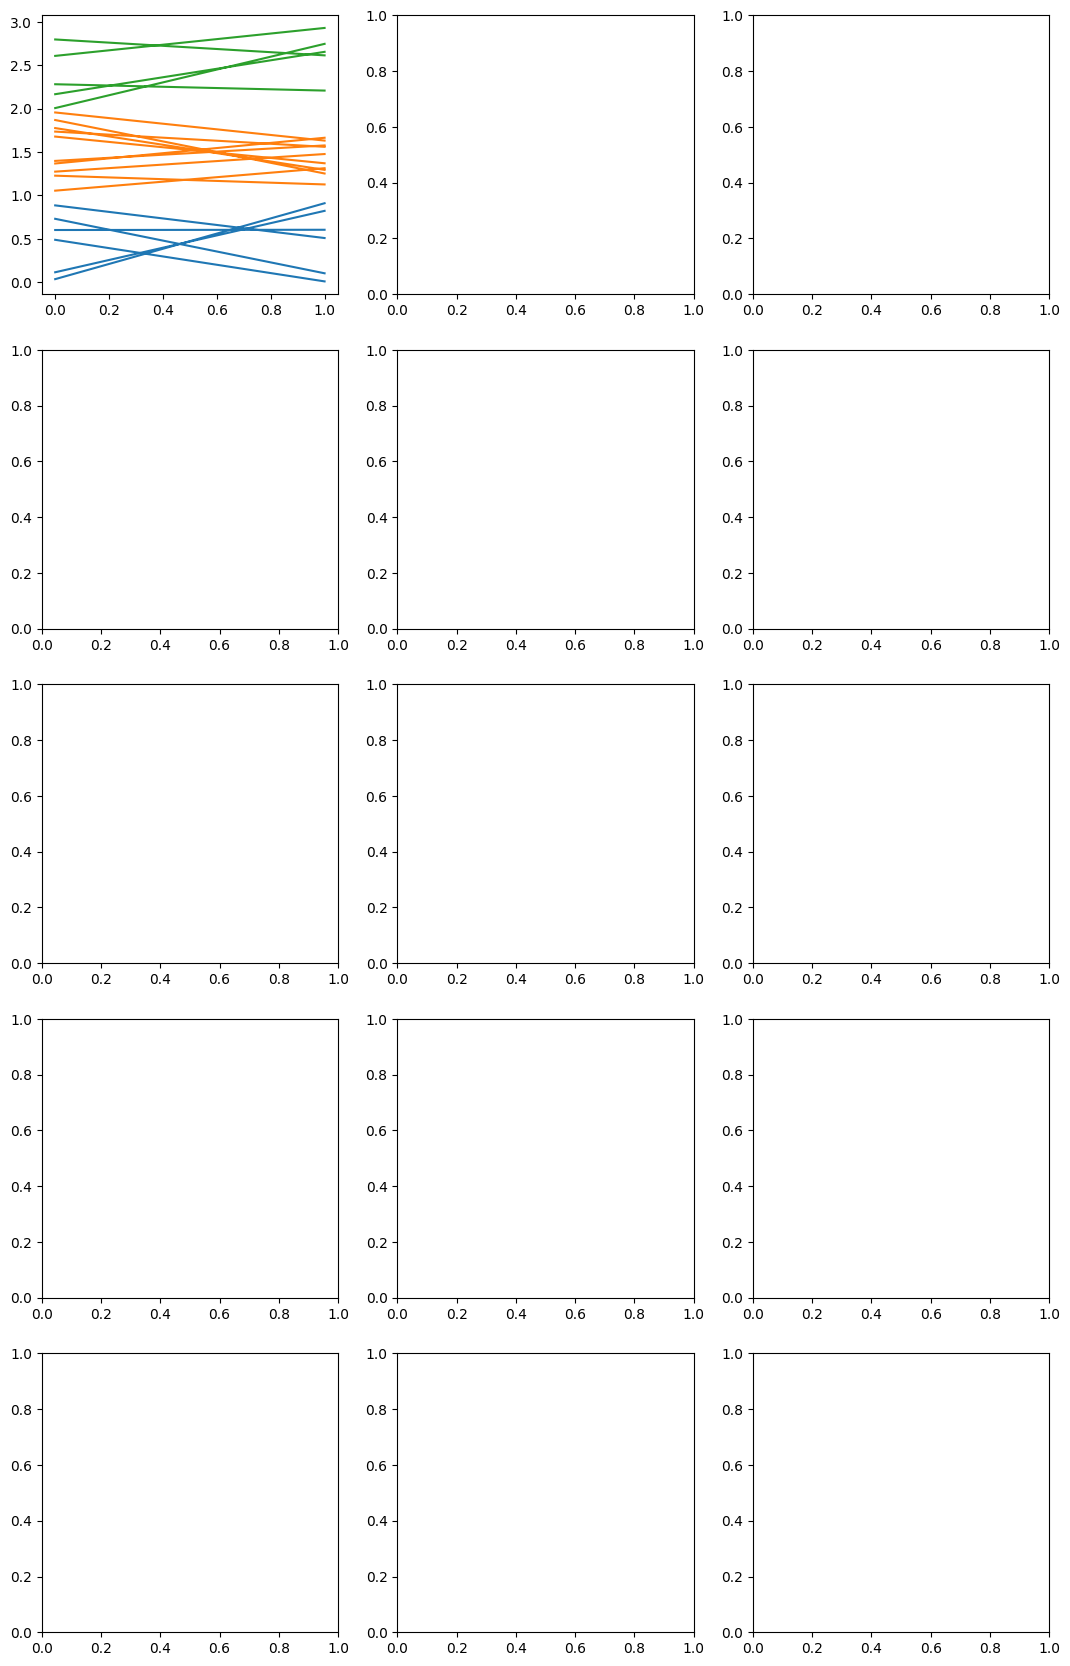

In [ ]:
cols = np.unique(df.columns.get_level_values(0))

fig, axs = plt.subplots(int(np.ceil(len(cols)/3)), 3, figsize=(13, 4.2*int(np.ceil(len(cols)/3))))

for icol, col in enumerate(cols):
    i_row = icol//3
    i_col = icol%3
    if i_row != 0:
        axs[i_row, i_col].set_title(col)
        df[col].plot(ax=axs[i_row, i_col], linewidth=2)
        axs[i_row, i_col].grid(True)
    else:
        for dim in range(3):
            dfi = df[f'Simplices dim {dim}'].loc[[0, 1]].transpose()
            dfi[np.nan] = np.nan
            y = np.concatenate(dfi.values)
            x = np.tile(dfi.columns, len(dfi))
            axs[i_row, i_col].plot(x, y, label=f'dim={dim}')

        x = df_transpositions[~df_transpositions['changes']]['time']
        y = df_transpositions[~df_transpositions['changes']]['value']
        if len(x) > 0:
            axs[i_row, i_col].scatter(x, y, color='darkgrey', marker='s', label='Not changing', linewidth=2)

        x = df_transpositions[df_transpositions['changes']]['time']
        y = df_transpositions[df_transpositions['changes']]['value']
        if len(x) > 0:
            axs[i_row, i_col].scatter(x, y, color='darkgrey', marker='D', label='Changing', linewidth=2)

        for transposition_type, marker in zip(['birth-birth', 'death-death', 'birth-death'], '*+o'):
            dfi = df_transpositions[(df_transpositions['type'] == transposition_type) &
                                    df_transpositions['switch'].isin(['switch forward', 'switch backward'])]
            x = dfi['time']
            y = dfi['value']
            if len(x) > 0:
                axs[i_row, i_col].scatter(x, y, marker=marker, color='black', zorder=2, label=transposition_type)
        axs[i_row, i_col].legend()
plt.tight_layout()
plt.show()

In [ ]:
df

Simplices dim 0                                                    \
                 (0,)      (1,)      (2,)      (3,)      (4,)      (5,)   
0.000        0.968572  0.773127  0.313177  0.888260  0.470749  0.434973   
0.005        0.964465  0.771884  0.312060  0.885938  0.470138  0.434090   
0.010        0.960357  0.770640  0.310943  0.883616  0.469526  0.433207   
0.015        0.956250  0.769397  0.309826  0.881294  0.468915  0.432323   
0.020        0.952143  0.768154  0.308709  0.878972  0.468304  0.431440   
...               ...       ...       ...       ...       ...       ...   
0.980        0.163532  0.529488  0.094287  0.433140  0.350981  0.261845   
0.985        0.159425  0.528245  0.093170  0.430818  0.350370  0.260961   
0.990        0.155317  0.527002  0.092054  0.428496  0.349759  0.260078   
0.995        0.151210  0.525759  0.090937  0.426174  0.349148  0.259195   
1.000        0.147103  0.524516  0.089820  0.423852  0.348537  0.258311   

      Simplices dim 1                                ...  \
               (0, 2)    (0, 4)    (0, 5)    (1, 2)  ...   
0.000        1.311347  1.082692  1.087236  1.210917  ...   
0.005        1.313425  1.084702  1.088198  1.210928  ...   
0.010        1.315504  1.086712  1.089160  1.210938  ...   
0.015        1.317582  1.088721  1.090121  1.210949  ...   
0.020        1.319660  1.090731  1.091083  1.210960  ...   
...               ...       ...       ...       ...  ...   
0.980        1.718662  1.476638  1.275720  1.212995  ...   
0.985        1.720740  1.478648  1.276682  1.213006  ...   
0.990        1.722818  1.480658  1.277644  1.213016  ...   
0.995        1.724897  1.482668  1.278605  1.213027  ...   
1.000        1.726975  1.484677  1.279567  1.213037  ...   

      number_of_minimal_nodes  number_of_nodes                                \
               Subposet dim 1 Full Depth Poset Subposet dim 0 Subposet dim 1   
0.000                       5               11              5              6   
0.005                       5               11              5              6   
0.010                       5               11              5              6   
0.015                       5               11              5              6   
0.020                       5               11              5              6   
...                       ...              ...            ...            ...   
0.980                       4               11              5              6   
0.985                       4               11              5              6   
0.990                       4               11              5              6   
0.995                       4               11              5              6   
1.000                       4               11              5              6   

      number_of_relations                                          width  \
         Full Depth Poset Subposet dim 0 Subposet dim 1 Full Depth Poset   
0.000                   5              3              2                9   
0.005                   5              3              2                9   
0.010                   5              3              2                9   
0.015                   5              3              2                9   
0.020                   5              3              2                9   
...                   ...            ...            ...              ...   
0.980                   7              3              4                6   
0.985                   7              3              4                6   
0.990                   7              3              4                6   
0.995                   7              3              4                6   
1.000                   7              3              4                6   

                                     
      Subposet dim 0 Subposet dim 1  
0.000              4              5  
0.005              4              5  
0.010              4              5  
0.015              4         

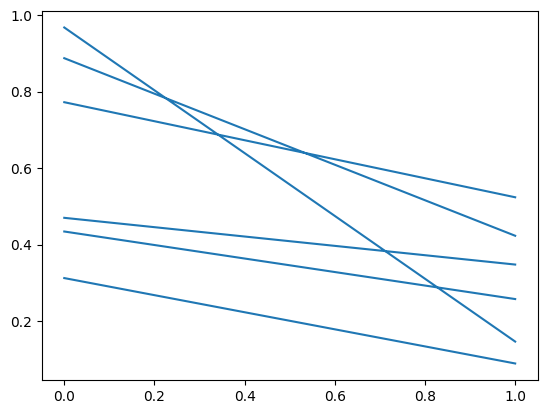

In [ ]:
i = 0
dfi = df[f'Simplices dim {i}'].loc[[0, 1]].transpose()
dfi[np.nan] = np.nan
y = np.concatenate(dfi.values)
x = np.tile(dfi.columns, len(dfi))
plt.plot(x, y)